In [ ]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from d_pooling import *
#from mgn import *
from d_tap_processing import *
#from global_tpok_mp import *

from d_TAP_MP_Attention import *
from GTF import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"""准备数据"""

In [2]:
number_trajectories=1
number_ts=200   #600
satart_number_ts=50
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.005
batch_size = 25
dataset_dir = '/root/data1/d_0.4_EMD'
path='/root/data1/d_slice_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

In [17]:
#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))
print(data_list_ori[0])
number=int(len(data_list_ori)/number_trajectories)

pool_num = [7000,6000,5000]#7793
perm_list=[]
for j in range(number_trajectories):
    x=data_list_ori[(j+1)*number-1].x
    edge_index=data_list_ori[(j+1)*number-1].edge_index
    
    perms=[]
    for i in range(len(pool_num)):
        ratio=pool_num[i]
        min_score= None
        x, edge_index,perm=TAPooling_Mod( x, ratio,min_score,edge_index,edge_attr=None, batch=None, attn=None)
        
        perms += [perm]
    perm_list.append(perms)

torch.save(perm_list,dataset_dir+'/perm_list.pt')

In [3]:
get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))
number=int(len(data_list_ori)/number_trajectories)

pool_num =[6500,4800,3900]#7793

data_list_ori=data_list_ori[:100]

data_list_pick=copy.deepcopy(data_list_ori)

perms=[]
perm_list=[]
ratio_1_list=[1400,1025,825]#[1600,1425,1025]
ratio_2_list=[1400,1025,825]#[1600,1425,1025]
ratio_3_list=[1400,1025,825]#[1600,1425,1025]

ratio_4_list=[1400,1025,825]#[1600,1425,1025]
ratio_5_list=[1000,800,500]
ratio_6_list=[2000,1500,1000]#[1000,800,500]


x_min_1=0
x_max_1=0.103
y_min_1=-0.0254
y_max_1=-0.005

x_min_2=0.103
x_max_2=0.206
y_min_2=-0.0254
y_max_2=-0.005

x_min_3=-0.003
x_max_3=0.103
y_min_3=0.005
y_max_3=0.0254

x_min_4=0.103
x_max_4=0.206
y_min_4=0.005
y_max_4=0.0254

x_min_5=0
x_max_5=0.206
y_min_5=-0.005
y_max_5=0.005

x_min_6=-0.0206
x_max_6=0.206
y_min_6=-0.0254
y_max_6=0.0254




for i in range(len(pool_num)):
      for j in range(len(data_list_ori)):
              if j==0:
                     sc=data_list_pick[j].x.new_zeros(data_list_pick[j].x.size(0))
              ratio_1=ratio_1_list[i]
              ratio_2=ratio_2_list[i]
              ratio_3=ratio_3_list[i]
              ratio_4=ratio_4_list[i]
              ratio_5=ratio_5_list[i]
              ratio_6=ratio_6_list[i]
              
              
              min_score= None
              x=data_list_pick[j].x
              edge_index=data_list_pick[j].edge_index
              pos=data_list_pick[j].mesh_pos
              #mask=x.new_zeros(x.size(0))
              mask=TAPooling_Mod(x, pos,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,
                                 x_min_1,x_max_1,y_min_1,y_max_1,
                   x_min_2,x_max_2,y_min_2,y_max_2,x_min_3,x_max_3,y_min_3,y_max_3,
                   x_min_4,x_max_4,y_min_4,y_max_4,
                   x_min_5,x_max_5,y_min_5,y_max_5,
                   
                   x_min_6,x_max_6,y_min_6,y_max_6,
                   
                   min_score,edge_index,
                                               edge_attr=None, batch=None, attn=None)
              #mask[perm]=1
              mask=mask.to('cpu')
              sc=sc+mask
              

      _, perm =sc.sort(dim=-1, descending=True)
      print(len(perm))
      mask = [torch.arange(pool_num[i], dtype=torch.long) ]
      perm = perm[mask]
      print(len(perm))
      perms += [perm]
      for k in range(len(data_list_ori)):
            edge_index=data_list_pick[k].edge_index
            edge_attr=data_list_pick[k].edge_attr
            edge_index, edge_attr, edge_mask = filter_adj(edge_index, edge_attr, perm,
                                           num_nodes=data_list_pick[k].x.size(0))
            data_list_pick[k]. x = data_list_pick[k]. x[perm]
            data_list_pick[k].mesh_pos  = data_list_pick[k].mesh_pos[perm]
            data_list_pick[k].edge_index= edge_index
            data_list_pick[k]. edge_attr =  edge_attr
            #print(data_list_pick[k]. x .shape,data_list_pick[k].edge_index.shape,data_list_pick[k]. edge_attr.shape)        
             
             
      

perm_list.append(perms)

torch.save(perm_list,dataset_dir+'/perm_list_150.pt')

/root/data1/d_slice_0
601


2024-10-20 16:29:42.627410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 16:29:46.214671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20970 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9c:00.0, compute capability: 8.9


Done collecting data!
Done saving data!
Output Location:  /root/data1/d_0.4_EMD/meshgraphnets_miniset111traj50200ts_vis.pt
200
7793
6500
6500
4800
4800
3900


optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                patience=5, threshold=0.0000001, threshold_mode='rel',
                                cooldown=0, min_lr=0.000001, eps=1e-08, verbose=True)


cuda


cuda:0
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/200 [00:29<1:37:39, 29.45s/Epochs]

Epoch: 0000,	Train mse: 0.94340236,	Train_RMSE: 0.97128902,	Train_acc: 0.97023559,	Test mse: 0.81668341,	Time: 29.44573355s


Training:   2%|▏         | 3/200 [01:26<1:34:16, 28.71s/Epochs]

Epoch: 0002,	Train mse: 0.53944858,	Train_RMSE: 0.73447164,	Train_acc: 0.73327696,	Test mse: 0.44560909,	Time: 28.29183269s


Training:   2%|▎         | 5/200 [02:22<1:31:54, 28.28s/Epochs]

Epoch: 0004,	Train mse: 0.32018698,	Train_RMSE: 0.56585067,	Train_acc: 0.56486809,	Test mse: 0.25638211,	Time: 27.80189681s


Training:   4%|▎         | 7/200 [03:19<1:30:56, 28.27s/Epochs]

Epoch: 0006,	Train mse: 0.18956960,	Train_RMSE: 0.43539592,	Train_acc: 0.43498817,	Test mse: 0.17610063,	Time: 28.52253604s


Training:   4%|▍         | 9/200 [04:17<1:31:24, 28.72s/Epochs]

Epoch: 0008,	Train mse: 0.12708403,	Train_RMSE: 0.35648847,	Train_acc: 0.35617635,	Test mse: 0.11463655,	Time: 29.61912417s


Training:   6%|▌         | 11/200 [05:14<1:30:31, 28.74s/Epochs]

Epoch: 0010,	Train mse: 0.08695591,	Train_RMSE: 0.29488288,	Train_acc: 0.29453284,	Test mse: 0.10196314,	Time: 29.70915222s


Training:   6%|▋         | 13/200 [06:11<1:29:09, 28.61s/Epochs]

Epoch: 0012,	Train mse: 0.06461568,	Train_RMSE: 0.25419615,	Train_acc: 0.25388789,	Test mse: 0.06075684,	Time: 28.70707607s


Training:   8%|▊         | 15/200 [07:07<1:27:38, 28.42s/Epochs]

Epoch: 0014,	Train mse: 0.05399364,	Train_RMSE: 0.23236533,	Train_acc: 0.23211460,	Test mse: 0.04786280,	Time: 28.21179175s


Training:   8%|▊         | 17/200 [08:04<1:26:17, 28.29s/Epochs]

Epoch: 0016,	Train mse: 0.04212237,	Train_RMSE: 0.20523736,	Train_acc: 0.20511042,	Test mse: 0.04057144,	Time: 27.80780339s


Training:  10%|▉         | 19/200 [09:03<1:27:48, 29.11s/Epochs]

Epoch: 0018,	Train mse: 0.03881517,	Train_RMSE: 0.19701566,	Train_acc: 0.19678660,	Test mse: 0.03782294,	Time: 29.60467792s


Training:  10%|█         | 21/200 [10:01<1:26:40, 29.05s/Epochs]

Epoch: 0020,	Train mse: 0.05458534,	Train_RMSE: 0.23363505,	Train_acc: 0.23253939,	Test mse: 0.05547496,	Time: 28.98792386s


Training:  12%|█▏        | 23/200 [10:58<1:24:37, 28.69s/Epochs]

Epoch: 0022,	Train mse: 0.03602988,	Train_RMSE: 0.18981539,	Train_acc: 0.18961544,	Test mse: 0.03182015,	Time: 28.28022909s


Training:  12%|█▎        | 25/200 [11:56<1:23:59, 28.80s/Epochs]

Epoch: 0024,	Train mse: 0.03008511,	Train_RMSE: 0.17345059,	Train_acc: 0.17334698,	Test mse: 0.02930957,	Time: 28.90578222s


Training:  14%|█▎        | 27/200 [12:55<1:24:13, 29.21s/Epochs]

Epoch: 0026,	Train mse: 0.02753804,	Train_RMSE: 0.16594591,	Train_acc: 0.16584681,	Test mse: 0.03028165,	Time: 28.99237251s


Training:  14%|█▍        | 29/200 [13:54<1:23:22, 29.25s/Epochs]

Epoch: 0028,	Train mse: 0.02950731,	Train_RMSE: 0.17177693,	Train_acc: 0.17150399,	Test mse: 0.02852317,	Time: 30.19883299s


Training:  16%|█▌        | 31/200 [14:50<1:21:02, 28.78s/Epochs]

Epoch: 0030,	Train mse: 0.02530844,	Train_RMSE: 0.15908628,	Train_acc: 0.15898608,	Test mse: 0.02328261,	Time: 28.59870934s


Training:  16%|█▋        | 33/200 [15:47<1:19:17, 28.49s/Epochs]

Epoch: 0032,	Train mse: 0.02277254,	Train_RMSE: 0.15090573,	Train_acc: 0.15082768,	Test mse: 0.02240276,	Time: 28.28081298s


Training:  18%|█▊        | 35/200 [16:44<1:18:25, 28.52s/Epochs]

Epoch: 0034,	Train mse: 0.03065313,	Train_RMSE: 0.17508035,	Train_acc: 0.17395765,	Test mse: 0.02498118,	Time: 28.71035790s


Training:  18%|█▊        | 37/200 [17:39<1:16:23, 28.12s/Epochs]

Epoch: 0036,	Train mse: 0.02314043,	Train_RMSE: 0.15211979,	Train_acc: 0.15200296,	Test mse: 0.02237045,	Time: 27.89177370s


Training:  20%|█▉        | 39/200 [18:36<1:16:19, 28.44s/Epochs]

Epoch: 0038,	Train mse: 0.02082075,	Train_RMSE: 0.14429398,	Train_acc: 0.14421599,	Test mse: 0.01997150,	Time: 28.99894404s


Training:  20%|██        | 41/200 [19:33<1:15:07, 28.35s/Epochs]

Epoch: 0040,	Train mse: 0.02079672,	Train_RMSE: 0.14421067,	Train_acc: 0.14409815,	Test mse: 0.02478302,	Time: 28.09843326s


Training:  22%|██▏       | 43/200 [20:29<1:13:50, 28.22s/Epochs]

Epoch: 0042,	Train mse: 0.02227245,	Train_RMSE: 0.14923958,	Train_acc: 0.14899805,	Test mse: 0.02244141,	Time: 28.09993505s


Training:  22%|██▎       | 45/200 [21:25<1:12:05, 27.91s/Epochs]

Epoch: 0044,	Train mse: 0.02045754,	Train_RMSE: 0.14302987,	Train_acc: 0.14295021,	Test mse: 0.01934330,	Time: 27.02278423s


Training:  24%|██▎       | 47/200 [22:20<1:11:20, 27.98s/Epochs]

Epoch: 0046,	Train mse: 0.01899762,	Train_RMSE: 0.13783185,	Train_acc: 0.13775460,	Test mse: 0.01861070,	Time: 28.50881362s


Training:  24%|██▍       | 49/200 [23:17<1:11:03, 28.24s/Epochs]

Epoch: 0048,	Train mse: 0.01994984,	Train_RMSE: 0.14124391,	Train_acc: 0.14102595,	Test mse: 0.01797864,	Time: 28.89873147s


Training:  26%|██▌       | 51/200 [24:15<1:11:03, 28.61s/Epochs]

Epoch: 0050,	Train mse: 0.01835982,	Train_RMSE: 0.13549840,	Train_acc: 0.13542256,	Test mse: 0.01846801,	Time: 28.89850855s


Training:  26%|██▋       | 53/200 [25:13<1:10:34, 28.80s/Epochs]

Epoch: 0052,	Train mse: 0.01758850,	Train_RMSE: 0.13262163,	Train_acc: 0.13252695,	Test mse: 0.02047478,	Time: 28.90563512s


Training:  28%|██▊       | 55/200 [26:09<1:08:19, 28.27s/Epochs]

Epoch: 0054,	Train mse: 0.02296971,	Train_RMSE: 0.15155762,	Train_acc: 0.15099138,	Test mse: 0.01803927,	Time: 27.09947491s


Training:  28%|██▊       | 56/200 [26:39<1:08:44, 28.64s/Epochs]

Epoch    56: reducing learning rate of group 0 to 5.0000e-04.


Training:  28%|██▊       | 57/200 [27:07<1:07:48, 28.45s/Epochs]

Epoch: 0056,	Train mse: 0.01740532,	Train_RMSE: 0.13192924,	Train_acc: 0.13185346,	Test mse: 0.01653412,	Time: 27.99876714s


Training:  30%|██▉       | 59/200 [28:05<1:08:10, 29.01s/Epochs]

Epoch: 0058,	Train mse: 0.01639819,	Train_RMSE: 0.12805542,	Train_acc: 0.12799069,	Test mse: 0.01610395,	Time: 30.50554156s


Training:  30%|███       | 61/200 [29:03<1:07:14, 29.02s/Epochs]

Epoch: 0060,	Train mse: 0.01588617,	Train_RMSE: 0.12604035,	Train_acc: 0.12597695,	Test mse: 0.01564253,	Time: 29.40587902s


Training:  32%|███▏      | 63/200 [30:08<1:09:26, 30.41s/Epochs]

Epoch: 0062,	Train mse: 0.01553121,	Train_RMSE: 0.12462426,	Train_acc: 0.12456145,	Test mse: 0.01531474,	Time: 29.68180656s


Training:  32%|███▎      | 65/200 [31:08<1:07:55, 30.19s/Epochs]

Epoch: 0064,	Train mse: 0.01523828,	Train_RMSE: 0.12344344,	Train_acc: 0.12338133,	Test mse: 0.01504002,	Time: 29.39231467s


Training:  34%|███▎      | 67/200 [32:05<1:04:53, 29.28s/Epochs]

Epoch: 0066,	Train mse: 0.01497275,	Train_RMSE: 0.12236320,	Train_acc: 0.12230162,	Test mse: 0.01478586,	Time: 28.38613200s


Training:  34%|███▍      | 69/200 [33:01<1:03:07, 28.91s/Epochs]

Epoch: 0068,	Train mse: 0.01472360,	Train_RMSE: 0.12134085,	Train_acc: 0.12127981,	Test mse: 0.01454253,	Time: 29.09871912s


Training:  36%|███▌      | 71/200 [33:58<1:01:35, 28.65s/Epochs]

Epoch: 0070,	Train mse: 0.01448623,	Train_RMSE: 0.12035875,	Train_acc: 0.12029823,	Test mse: 0.01431600,	Time: 28.30361342s


Training:  36%|███▋      | 73/200 [34:57<1:01:11, 28.91s/Epochs]

Epoch: 0072,	Train mse: 0.01426003,	Train_RMSE: 0.11941536,	Train_acc: 0.11935529,	Test mse: 0.01408846,	Time: 28.51254725s


Training:  38%|███▊      | 75/200 [35:52<59:05, 28.37s/Epochs]  

Epoch: 0074,	Train mse: 0.01404202,	Train_RMSE: 0.11849902,	Train_acc: 0.11843941,	Test mse: 0.01387278,	Time: 28.10151577s


Training:  38%|███▊      | 77/200 [36:49<58:00, 28.29s/Epochs]

Epoch: 0076,	Train mse: 0.01382985,	Train_RMSE: 0.11760040,	Train_acc: 0.11754127,	Test mse: 0.01366354,	Time: 28.10071921s


Training:  40%|███▉      | 79/200 [37:47<57:54, 28.72s/Epochs]

Epoch: 0078,	Train mse: 0.01362531,	Train_RMSE: 0.11672750,	Train_acc: 0.11666880,	Test mse: 0.01345911,	Time: 28.49956703s


Training:  40%|████      | 81/200 [38:46<57:25, 28.95s/Epochs]

Epoch: 0080,	Train mse: 0.01342778,	Train_RMSE: 0.11587831,	Train_acc: 0.11582008,	Test mse: 0.01325026,	Time: 28.87810946s


Training:  42%|████▏     | 83/200 [39:41<55:01, 28.21s/Epochs]

Epoch: 0082,	Train mse: 0.01323844,	Train_RMSE: 0.11505843,	Train_acc: 0.11500065,	Test mse: 0.01305438,	Time: 27.29349923s


Training:  42%|████▎     | 85/200 [40:36<53:30, 27.91s/Epochs]

Epoch: 0084,	Train mse: 0.01302382,	Train_RMSE: 0.11412194,	Train_acc: 0.11406446,	Test mse: 0.01287994,	Time: 27.50413680s


Training:  44%|████▎     | 87/200 [41:32<52:31, 27.89s/Epochs]

Epoch: 0086,	Train mse: 0.01285574,	Train_RMSE: 0.11338314,	Train_acc: 0.11332516,	Test mse: 0.01316869,	Time: 27.67687821s


Training:  44%|████▍     | 89/200 [42:28<51:55, 28.07s/Epochs]

Epoch: 0088,	Train mse: 0.01299631,	Train_RMSE: 0.11400137,	Train_acc: 0.11393512,	Test mse: 0.01285911,	Time: 28.90250587s


Training:  46%|████▌     | 91/200 [43:29<53:24, 29.40s/Epochs]

Epoch: 0090,	Train mse: 0.01261783,	Train_RMSE: 0.11232912,	Train_acc: 0.11226982,	Test mse: 0.01249569,	Time: 31.78752446s


Training:  46%|████▋     | 93/200 [44:29<52:26, 29.40s/Epochs]

Epoch: 0092,	Train mse: 0.01227789,	Train_RMSE: 0.11080566,	Train_acc: 0.11075010,	Test mse: 0.01205760,	Time: 28.21323299s


Training:  48%|████▊     | 95/200 [45:26<50:54, 29.09s/Epochs]

Epoch: 0094,	Train mse: 0.01202317,	Train_RMSE: 0.10965024,	Train_acc: 0.10959500,	Test mse: 0.01188805,	Time: 28.51245427s


Training:  48%|████▊     | 97/200 [46:22<48:38, 28.34s/Epochs]

Epoch: 0096,	Train mse: 0.01374312,	Train_RMSE: 0.11723104,	Train_acc: 0.11712531,	Test mse: 0.01179370,	Time: 27.41429377s


Training:  50%|████▉     | 99/200 [47:17<47:15, 28.07s/Epochs]

Epoch: 0098,	Train mse: 0.01194913,	Train_RMSE: 0.10931209,	Train_acc: 0.10925386,	Test mse: 0.01148187,	Time: 27.48576975s


Training:  50%|█████     | 101/200 [48:14<46:33, 28.22s/Epochs]

Epoch: 0100,	Train mse: 0.01158734,	Train_RMSE: 0.10764449,	Train_acc: 0.10758869,	Test mse: 0.01127591,	Time: 28.39287257s


Training:  52%|█████▏    | 103/200 [49:12<46:26, 28.73s/Epochs]

Epoch: 0102,	Train mse: 0.01131647,	Train_RMSE: 0.10637890,	Train_acc: 0.10632510,	Test mse: 0.01124665,	Time: 29.99863839s


Training:  52%|█████▎    | 105/200 [50:10<45:48, 28.93s/Epochs]

Epoch: 0104,	Train mse: 0.01335266,	Train_RMSE: 0.11555372,	Train_acc: 0.11543655,	Test mse: 0.01119322,	Time: 29.01130438s


Training:  54%|█████▎    | 107/200 [51:07<44:31, 28.72s/Epochs]

Epoch: 0106,	Train mse: 0.01127247,	Train_RMSE: 0.10617187,	Train_acc: 0.10611261,	Test mse: 0.01081038,	Time: 28.61250043s


Training:  55%|█████▍    | 109/200 [52:04<43:10, 28.46s/Epochs]

Epoch: 0108,	Train mse: 0.01088111,	Train_RMSE: 0.10431255,	Train_acc: 0.10425784,	Test mse: 0.01078764,	Time: 28.29639292s


Training:  56%|█████▌    | 111/200 [53:01<42:18, 28.52s/Epochs]

Epoch: 0110,	Train mse: 0.01075927,	Train_RMSE: 0.10372690,	Train_acc: 0.10366895,	Test mse: 0.01118289,	Time: 29.32560182s


Training:  56%|█████▋    | 113/200 [53:58<41:28, 28.60s/Epochs]

Epoch: 0112,	Train mse: 0.01121687,	Train_RMSE: 0.10590975,	Train_acc: 0.10582980,	Test mse: 0.01142609,	Time: 28.38334584s


Training:  57%|█████▊    | 115/200 [54:54<40:01, 28.25s/Epochs]

Epoch: 0114,	Train mse: 0.01053362,	Train_RMSE: 0.10263342,	Train_acc: 0.10257743,	Test mse: 0.01013576,	Time: 27.72011805s


Training:  58%|█████▊    | 117/200 [55:49<38:39, 27.94s/Epochs]

Epoch: 0116,	Train mse: 0.01027319,	Train_RMSE: 0.10135676,	Train_acc: 0.10130547,	Test mse: 0.01040948,	Time: 27.38702774s


Training:  60%|█████▉    | 119/200 [56:47<38:07, 28.24s/Epochs]

Epoch: 0118,	Train mse: 0.01041004,	Train_RMSE: 0.10202959,	Train_acc: 0.10196204,	Test mse: 0.00989235,	Time: 28.19853926s


Training:  60%|██████    | 121/200 [57:44<37:17, 28.32s/Epochs]

Epoch: 0120,	Train mse: 0.00988497,	Train_RMSE: 0.09942319,	Train_acc: 0.09937305,	Test mse: 0.00974032,	Time: 27.69585490s


Training:  62%|██████▏   | 123/200 [58:39<35:52, 27.95s/Epochs]

Epoch: 0122,	Train mse: 0.01020678,	Train_RMSE: 0.10102859,	Train_acc: 0.10094278,	Test mse: 0.01242271,	Time: 27.59377289s


Training:  62%|██████▎   | 125/200 [59:36<35:19, 28.26s/Epochs]

Epoch: 0124,	Train mse: 0.01118153,	Train_RMSE: 0.10574276,	Train_acc: 0.10565415,	Test mse: 0.01081518,	Time: 29.08139086s


Training:  64%|██████▎   | 127/200 [1:00:34<34:56, 28.72s/Epochs]

Epoch: 0126,	Train mse: 0.01004482,	Train_RMSE: 0.10022383,	Train_acc: 0.10015994,	Test mse: 0.00989928,	Time: 28.71202588s


Training:  64%|██████▍   | 129/200 [1:01:33<34:19, 29.01s/Epochs]

Epoch: 0128,	Train mse: 0.00966246,	Train_RMSE: 0.09829782,	Train_acc: 0.09824686,	Test mse: 0.00936388,	Time: 29.49133444s


Training:  66%|██████▌   | 131/200 [1:02:30<33:14, 28.91s/Epochs]

Epoch: 0130,	Train mse: 0.00940742,	Train_RMSE: 0.09699187,	Train_acc: 0.09694270,	Test mse: 0.00921230,	Time: 28.89472771s


Training:  66%|██████▋   | 133/200 [1:03:28<32:21, 28.98s/Epochs]

Epoch: 0132,	Train mse: 0.00920674,	Train_RMSE: 0.09595176,	Train_acc: 0.09590317,	Test mse: 0.00913747,	Time: 29.20515990s


Training:  68%|██████▊   | 135/200 [1:04:26<31:12, 28.81s/Epochs]

Epoch: 0134,	Train mse: 0.01201025,	Train_RMSE: 0.10959129,	Train_acc: 0.10921647,	Test mse: 0.01064523,	Time: 27.91812253s


Training:  68%|██████▊   | 137/200 [1:05:21<29:32, 28.14s/Epochs]

Epoch: 0136,	Train mse: 0.00954655,	Train_RMSE: 0.09770647,	Train_acc: 0.09764113,	Test mse: 0.00904815,	Time: 27.29764462s


Training:  70%|██████▉   | 139/200 [1:06:17<28:31, 28.06s/Epochs]

Epoch: 0138,	Train mse: 0.00906028,	Train_RMSE: 0.09518548,	Train_acc: 0.09513592,	Test mse: 0.00889943,	Time: 28.09817910s


Training:  70%|███████   | 141/200 [1:07:15<27:58, 28.45s/Epochs]

Epoch: 0140,	Train mse: 0.00890674,	Train_RMSE: 0.09437555,	Train_acc: 0.09432735,	Test mse: 0.00878927,	Time: 28.90593529s


Training:  72%|███████▏  | 143/200 [1:08:12<27:17, 28.73s/Epochs]

Epoch: 0142,	Train mse: 0.01213918,	Train_RMSE: 0.11017793,	Train_acc: 0.10988340,	Test mse: 0.00911039,	Time: 29.49666095s


Training:  72%|███████▎  | 145/200 [1:09:09<26:05, 28.47s/Epochs]

Epoch: 0144,	Train mse: 0.00931180,	Train_RMSE: 0.09649769,	Train_acc: 0.09643064,	Test mse: 0.00889297,	Time: 27.81014729s


Training:  74%|███████▎  | 147/200 [1:10:05<24:53, 28.18s/Epochs]

Epoch: 0146,	Train mse: 0.00882348,	Train_RMSE: 0.09393340,	Train_acc: 0.09388516,	Test mse: 0.00874512,	Time: 27.89893484s


Training:  74%|███████▍  | 149/200 [1:11:00<23:45, 27.95s/Epochs]

Epoch: 0148,	Train mse: 0.00860905,	Train_RMSE: 0.09278495,	Train_acc: 0.09273811,	Test mse: 0.00850586,	Time: 27.89897823s


Training:  76%|███████▌  | 151/200 [1:11:57<22:55, 28.08s/Epochs]

Epoch: 0150,	Train mse: 0.00926074,	Train_RMSE: 0.09623275,	Train_acc: 0.09613106,	Test mse: 0.01108144,	Time: 27.99865389s


Training:  76%|███████▋  | 153/200 [1:12:53<21:55, 27.99s/Epochs]

Epoch: 0152,	Train mse: 0.00892167,	Train_RMSE: 0.09445457,	Train_acc: 0.09439392,	Test mse: 0.00839824,	Time: 27.89790130s


Training:  78%|███████▊  | 155/200 [1:13:50<21:17, 28.38s/Epochs]

Epoch: 0154,	Train mse: 0.00872016,	Train_RMSE: 0.09338180,	Train_acc: 0.09332521,	Test mse: 0.00854673,	Time: 28.30539489s


Training:  78%|███████▊  | 157/200 [1:14:48<20:31, 28.63s/Epochs]

Epoch: 0156,	Train mse: 0.00862292,	Train_RMSE: 0.09285967,	Train_acc: 0.09280978,	Test mse: 0.00841600,	Time: 28.78960943s


Training:  80%|███████▉  | 159/200 [1:15:47<19:45, 28.92s/Epochs]

Epoch: 0158,	Train mse: 0.00896230,	Train_RMSE: 0.09466944,	Train_acc: 0.09460346,	Test mse: 0.00967206,	Time: 28.69991136s
Epoch   159: reducing learning rate of group 0 to 2.5000e-04.


Training:  80%|████████  | 161/200 [1:16:44<18:43, 28.80s/Epochs]

Epoch: 0160,	Train mse: 0.00842599,	Train_RMSE: 0.09179318,	Train_acc: 0.09173252,	Test mse: 0.00843337,	Time: 28.18973947s


Training:  82%|████████▏ | 163/200 [1:17:40<17:30, 28.38s/Epochs]

Epoch: 0162,	Train mse: 0.00821456,	Train_RMSE: 0.09063422,	Train_acc: 0.09058689,	Test mse: 0.00815502,	Time: 28.30637026s


Training:  82%|████████▎ | 165/200 [1:18:36<16:29, 28.26s/Epochs]

Epoch: 0164,	Train mse: 0.00813334,	Train_RMSE: 0.09018505,	Train_acc: 0.09013901,	Test mse: 0.00805255,	Time: 27.89865589s


Training:  84%|████████▎ | 167/200 [1:19:32<15:20, 27.91s/Epochs]

Epoch: 0166,	Train mse: 0.00808917,	Train_RMSE: 0.08993983,	Train_acc: 0.08989408,	Test mse: 0.00800420,	Time: 27.40867257s


Training:  84%|████████▍ | 169/200 [1:20:29<14:34, 28.19s/Epochs]

Epoch: 0168,	Train mse: 0.00805349,	Train_RMSE: 0.08974125,	Train_acc: 0.08969565,	Test mse: 0.00796718,	Time: 28.59633899s


Training:  86%|████████▌ | 171/200 [1:21:24<13:32, 28.03s/Epochs]

Epoch: 0170,	Train mse: 0.00801800,	Train_RMSE: 0.08954327,	Train_acc: 0.08949774,	Test mse: 0.00793350,	Time: 27.90621352s


Training:  86%|████████▋ | 173/200 [1:22:20<12:35, 28.00s/Epochs]

Epoch: 0172,	Train mse: 0.00798446,	Train_RMSE: 0.08935581,	Train_acc: 0.08931037,	Test mse: 0.00790076,	Time: 27.60953927s


Training:  88%|████████▊ | 175/200 [1:23:17<11:44, 28.19s/Epochs]

Epoch: 0174,	Train mse: 0.00795160,	Train_RMSE: 0.08917176,	Train_acc: 0.08912640,	Test mse: 0.00786846,	Time: 28.48575950s


Training:  88%|████████▊ | 177/200 [1:24:13<10:44, 28.04s/Epochs]

Epoch: 0176,	Train mse: 0.00791870,	Train_RMSE: 0.08898707,	Train_acc: 0.08894180,	Test mse: 0.00783679,	Time: 28.59325242s


Training:  90%|████████▉ | 179/200 [1:25:08<09:45, 27.90s/Epochs]

Epoch: 0178,	Train mse: 0.00788600,	Train_RMSE: 0.08880317,	Train_acc: 0.08875800,	Test mse: 0.00780518,	Time: 27.59866118s


Training:  90%|█████████ | 181/200 [1:26:04<08:49, 27.87s/Epochs]

Epoch: 0180,	Train mse: 0.00785418,	Train_RMSE: 0.08862379,	Train_acc: 0.08857867,	Test mse: 0.00777315,	Time: 27.79643893s


Training:  92%|█████████▏| 183/200 [1:27:00<07:53, 27.85s/Epochs]

Epoch: 0182,	Train mse: 0.00782239,	Train_RMSE: 0.08844430,	Train_acc: 0.08839925,	Test mse: 0.00774127,	Time: 27.71202707s


Training:  92%|█████████▎| 185/200 [1:27:55<06:55, 27.73s/Epochs]

Epoch: 0184,	Train mse: 0.00779075,	Train_RMSE: 0.08826521,	Train_acc: 0.08822025,	Test mse: 0.00770967,	Time: 27.20597410s


Training:  94%|█████████▎| 187/200 [1:28:51<05:59, 27.68s/Epochs]

Epoch: 0186,	Train mse: 0.00775827,	Train_RMSE: 0.08808104,	Train_acc: 0.08803617,	Test mse: 0.00767565,	Time: 26.90587401s


Training:  94%|█████████▍| 189/200 [1:29:46<05:04, 27.66s/Epochs]

Epoch: 0188,	Train mse: 0.00772576,	Train_RMSE: 0.08789629,	Train_acc: 0.08785153,	Test mse: 0.00764382,	Time: 27.80530572s


Training:  96%|█████████▌| 191/200 [1:30:42<04:10, 27.87s/Epochs]

Epoch: 0190,	Train mse: 0.00769266,	Train_RMSE: 0.08770781,	Train_acc: 0.08766314,	Test mse: 0.00761278,	Time: 28.19868588s


Training:  96%|█████████▋| 193/200 [1:31:37<03:15, 27.88s/Epochs]

Epoch: 0192,	Train mse: 0.00766034,	Train_RMSE: 0.08752335,	Train_acc: 0.08747877,	Test mse: 0.00758094,	Time: 28.27974534s


Training:  98%|█████████▊| 195/200 [1:32:34<02:19, 27.98s/Epochs]

Epoch: 0194,	Train mse: 0.00762900,	Train_RMSE: 0.08734413,	Train_acc: 0.08729963,	Test mse: 0.00754964,	Time: 27.99805427s


Training:  98%|█████████▊| 197/200 [1:33:28<01:23, 27.69s/Epochs]

Epoch: 0196,	Train mse: 0.00759677,	Train_RMSE: 0.08715947,	Train_acc: 0.08711506,	Test mse: 0.00751792,	Time: 27.49261856s


Training: 100%|█████████▉| 199/200 [1:34:24<00:27, 27.80s/Epochs]

Epoch: 0198,	Train mse: 0.00756466,	Train_RMSE: 0.08697505,	Train_acc: 0.08693073,	Test mse: 0.00748653,	Time: 27.81989861s


Training: 100%|██████████| 200/200 [1:34:52<00:00, 28.46s/Epochs]


Model.state_dict:
node_encode.0.weight 	 torch.Size([26, 2])
node_encode.0.bias 	 torch.Size([26])
node_encode.1.weight 	 torch.Size([26, 26])
node_encode.1.bias 	 torch.Size([26])
node_encode.2.weight 	 torch.Size([26, 26])
node_encode.2.bias 	 torch.Size([26])
node_encode.3.weight 	 torch.Size([26, 26])
node_encode.3.bias 	 torch.Size([26])
node_encode_norm.weight 	 torch.Size([26])
node_encode_norm.bias 	 torch.Size([26])
edge_encode.0.weight 	 torch.Size([26, 3])
edge_encode.0.bias 	 torch.Size([26])
edge_encode.1.weight 	 torch.Size([26, 26])
edge_encode.1.bias 	 torch.Size([26])
edge_encode.2.weight 	 torch.Size([26, 26])
edge_encode.2.bias 	 torch.Size([26])
edge_encode.3.weight 	 torch.Size([26, 26])
edge_encode.3.bias 	 torch.Size([26])
edge_encode_norm.weight 	 torch.Size([26])
edge_encode_norm.bias 	 torch.Size([26])
edge_down_mps.0.0.0.weight 	 torch.Size([26, 78])
edge_down_mps.0.0.0.bias 	 torch.Size([26])
edge_down_mps.0.0.1.weight 	 torch.Size([26, 26])
edge_down_mps.0.

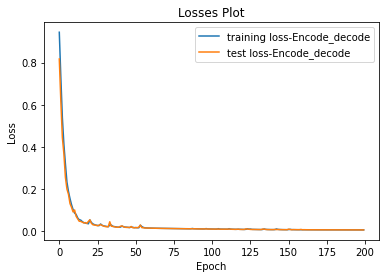

In [3]:
SEED = 42    #42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/d_0.4_EMD/Encode_state_dict.pt'
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'
pathED = '/root/data1/d_0.4_EMD/ED_state_dict.pt'
epochs = 200

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]  #2
in_channels_edge = sample.edge_attr.shape[1]  #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node
batch_size =25       #改25
n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
#model.load_state_dict(torch.load(pathED), strict=False)
train_hist, test_hist=train(epochs, model, perm_list,train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,pathED,pathD,pathE)
plot_dir='/root/data1/d_0.4_EMD/loss/'
save_DEplots(train_hist, test_hist,plot_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00025) #weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                patience=5, threshold=0.0000001, threshold_mode='rel',
                                cooldown=0, min_lr=0.000001, eps=1e-08, verbose=True)

cuda
cuda:0
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/200 [00:30<1:39:39, 30.05s/Epochs]

Epoch: 0000,	Train mse: 0.07356535,	Train_RMSE: 0.27122934,	Train_acc: 0.24391073,	Test mse: 0.01597888,	Time: 30.04798818s


Training:   2%|▏         | 3/200 [01:26<1:33:47, 28.56s/Epochs]

Epoch: 0002,	Train mse: 0.02121144,	Train_RMSE: 0.14564149,	Train_acc: 0.14352810,	Test mse: 0.01609485,	Time: 28.09249926s


Training:   2%|▎         | 5/200 [02:21<1:30:51, 27.95s/Epochs]

Epoch: 0004,	Train mse: 0.01173479,	Train_RMSE: 0.10832724,	Train_acc: 0.10799881,	Test mse: 0.01120480,	Time: 27.40650821s


Training:   4%|▎         | 7/200 [03:16<1:28:49, 27.61s/Epochs]

Epoch: 0006,	Train mse: 0.00904355,	Train_RMSE: 0.09509758,	Train_acc: 0.09502616,	Test mse: 0.00859056,	Time: 27.09011912s


Training:   4%|▍         | 9/200 [04:11<1:28:17, 27.74s/Epochs]

Epoch: 0008,	Train mse: 0.00818232,	Train_RMSE: 0.09045619,	Train_acc: 0.09040941,	Test mse: 0.00806485,	Time: 28.00552464s


Training:   6%|▌         | 11/200 [05:06<1:26:30, 27.46s/Epochs]

Epoch: 0010,	Train mse: 0.00790559,	Train_RMSE: 0.08891338,	Train_acc: 0.08886830,	Test mse: 0.00778504,	Time: 26.79545403s


Training:   6%|▋         | 13/200 [06:02<1:26:36, 27.79s/Epochs]

Epoch: 0012,	Train mse: 0.00777349,	Train_RMSE: 0.08816742,	Train_acc: 0.08812260,	Test mse: 0.00767829,	Time: 28.58043551s


Training:   8%|▊         | 15/200 [06:57<1:25:18, 27.67s/Epochs]

Epoch: 0014,	Train mse: 0.00769315,	Train_RMSE: 0.08771060,	Train_acc: 0.08766600,	Test mse: 0.00760998,	Time: 27.57882023s


Training:   8%|▊         | 17/200 [07:52<1:24:01, 27.55s/Epochs]

Epoch: 0016,	Train mse: 0.00763757,	Train_RMSE: 0.08739319,	Train_acc: 0.08734872,	Test mse: 0.00755760,	Time: 27.10183239s


Training:  10%|▉         | 19/200 [08:47<1:23:07, 27.56s/Epochs]

Epoch: 0018,	Train mse: 0.00759529,	Train_RMSE: 0.08715094,	Train_acc: 0.08710657,	Test mse: 0.00751732,	Time: 27.40645671s


Training:  10%|█         | 21/200 [09:42<1:22:11, 27.55s/Epochs]

Epoch: 0020,	Train mse: 0.00756099,	Train_RMSE: 0.08695395,	Train_acc: 0.08690967,	Test mse: 0.00748446,	Time: 27.49618459s


Training:  12%|█▏        | 23/200 [10:40<1:22:57, 28.12s/Epochs]

Epoch: 0022,	Train mse: 0.00753209,	Train_RMSE: 0.08678761,	Train_acc: 0.08674338,	Test mse: 0.00745583,	Time: 28.99846601s


Training:  12%|█▎        | 25/200 [11:35<1:21:26, 27.92s/Epochs]

Epoch: 0024,	Train mse: 0.00750481,	Train_RMSE: 0.08663032,	Train_acc: 0.08658617,	Test mse: 0.00742904,	Time: 27.39657283s


Training:  14%|█▎        | 27/200 [12:30<1:20:04, 27.77s/Epochs]

Epoch: 0026,	Train mse: 0.00747927,	Train_RMSE: 0.08648277,	Train_acc: 0.08643870,	Test mse: 0.00740339,	Time: 27.99383402s


Training:  14%|█▍        | 29/200 [13:28<1:20:17, 28.17s/Epochs]

Epoch: 0028,	Train mse: 0.00745403,	Train_RMSE: 0.08633674,	Train_acc: 0.08629273,	Test mse: 0.00737972,	Time: 28.38583040s


Training:  16%|█▌        | 31/200 [14:22<1:18:11, 27.76s/Epochs]

Epoch: 0030,	Train mse: 0.00743057,	Train_RMSE: 0.08620073,	Train_acc: 0.08615678,	Test mse: 0.00735638,	Time: 26.90281200s


Training:  16%|█▋        | 33/200 [15:18<1:17:02, 27.68s/Epochs]

Epoch: 0032,	Train mse: 0.00740725,	Train_RMSE: 0.08606538,	Train_acc: 0.08602151,	Test mse: 0.00733381,	Time: 27.31423020s


Training:  18%|█▊        | 35/200 [16:13<1:15:34, 27.48s/Epochs]

Epoch: 0034,	Train mse: 0.00738387,	Train_RMSE: 0.08592945,	Train_acc: 0.08588564,	Test mse: 0.00731034,	Time: 26.80326271s


Training:  18%|█▊        | 37/200 [17:07<1:14:37, 27.47s/Epochs]

Epoch: 0036,	Train mse: 0.00736068,	Train_RMSE: 0.08579438,	Train_acc: 0.08575062,	Test mse: 0.00728756,	Time: 27.49139404s


Training:  20%|█▉        | 39/200 [18:04<1:14:52, 27.90s/Epochs]

Epoch: 0038,	Train mse: 0.00733766,	Train_RMSE: 0.08566016,	Train_acc: 0.08561645,	Test mse: 0.00726436,	Time: 28.39504004s


Training:  20%|██        | 41/200 [19:00<1:14:06, 27.97s/Epochs]

Epoch: 0040,	Train mse: 0.00731420,	Train_RMSE: 0.08552311,	Train_acc: 0.08547948,	Test mse: 0.00724272,	Time: 27.69510460s


Training:  22%|██▏       | 43/200 [19:55<1:12:11, 27.59s/Epochs]

Epoch: 0042,	Train mse: 0.00729110,	Train_RMSE: 0.08538792,	Train_acc: 0.08534434,	Test mse: 0.00721795,	Time: 27.37180257s


Training:  22%|██▎       | 45/200 [20:50<1:11:38, 27.74s/Epochs]

Epoch: 0044,	Train mse: 0.00726782,	Train_RMSE: 0.08525150,	Train_acc: 0.08520798,	Test mse: 0.00719845,	Time: 27.99176598s


Training:  24%|██▎       | 47/200 [21:47<1:11:34, 28.07s/Epochs]

Epoch: 0046,	Train mse: 0.00724353,	Train_RMSE: 0.08510892,	Train_acc: 0.08506547,	Test mse: 0.00717633,	Time: 28.08634496s


Training:  24%|██▍       | 49/200 [22:44<1:10:46, 28.13s/Epochs]

Epoch: 0048,	Train mse: 0.00752651,	Train_RMSE: 0.08675547,	Train_acc: 0.08670691,	Test mse: 0.00746136,	Time: 27.59680057s


Training:  26%|██▌       | 51/200 [23:39<1:08:53, 27.74s/Epochs]

Epoch: 0050,	Train mse: 0.00727364,	Train_RMSE: 0.08528567,	Train_acc: 0.08524122,	Test mse: 0.00718587,	Time: 27.21009231s


Training:  26%|██▋       | 53/200 [24:35<1:08:13, 27.84s/Epochs]

Epoch: 0052,	Train mse: 0.00720367,	Train_RMSE: 0.08487441,	Train_acc: 0.08483084,	Test mse: 0.00715818,	Time: 27.70739818s


Training:  28%|██▊       | 55/200 [25:30<1:07:05, 27.76s/Epochs]

Epoch: 0054,	Train mse: 0.00714835,	Train_RMSE: 0.08454791,	Train_acc: 0.08450472,	Test mse: 0.00708290,	Time: 28.10263085s


Training:  28%|██▊       | 57/200 [26:24<1:05:15, 27.38s/Epochs]

Epoch: 0056,	Train mse: 0.00733980,	Train_RMSE: 0.08567265,	Train_acc: 0.08562039,	Test mse: 0.00782496,	Time: 27.21140122s


Training:  30%|██▉       | 59/200 [27:18<1:04:19, 27.37s/Epochs]

Epoch: 0058,	Train mse: 0.00723500,	Train_RMSE: 0.08505878,	Train_acc: 0.08501302,	Test mse: 0.00712258,	Time: 27.41952348s


Training:  30%|███       | 61/200 [28:13<1:03:25, 27.37s/Epochs]

Epoch: 0060,	Train mse: 0.00714757,	Train_RMSE: 0.08454333,	Train_acc: 0.08449917,	Test mse: 0.00711631,	Time: 27.51171827s


Training:  32%|███▏      | 63/200 [29:08<1:02:48, 27.51s/Epochs]

Epoch: 0062,	Train mse: 0.00707239,	Train_RMSE: 0.08409749,	Train_acc: 0.08405440,	Test mse: 0.00700192,	Time: 27.59044576s


Training:  32%|███▎      | 65/200 [30:04<1:02:21, 27.71s/Epochs]

Epoch: 0064,	Train mse: 0.00702606,	Train_RMSE: 0.08382162,	Train_acc: 0.08377879,	Test mse: 0.00695674,	Time: 27.70220447s


Training:  34%|███▎      | 67/200 [31:00<1:01:43, 27.84s/Epochs]

Epoch: 0066,	Train mse: 0.00736941,	Train_RMSE: 0.08584528,	Train_acc: 0.08578192,	Test mse: 0.00816118,	Time: 28.29637122s


Training:  34%|███▍      | 69/200 [31:56<1:00:58, 27.93s/Epochs]

Epoch: 0068,	Train mse: 0.00718980,	Train_RMSE: 0.08479268,	Train_acc: 0.08474477,	Test mse: 0.00699785,	Time: 28.29625893s


Training:  36%|███▌      | 71/200 [32:51<59:46, 27.80s/Epochs]  

Epoch: 0070,	Train mse: 0.00710707,	Train_RMSE: 0.08430344,	Train_acc: 0.08425773,	Test mse: 0.00702796,	Time: 27.80383325s


Training:  36%|███▋      | 73/200 [33:47<58:52, 27.81s/Epochs]

Epoch: 0072,	Train mse: 0.00698280,	Train_RMSE: 0.08356316,	Train_acc: 0.08352030,	Test mse: 0.00685965,	Time: 27.90678287s


Training:  38%|███▊      | 75/200 [34:43<58:11, 27.93s/Epochs]

Epoch: 0074,	Train mse: 0.00693225,	Train_RMSE: 0.08326013,	Train_acc: 0.08321764,	Test mse: 0.00684757,	Time: 27.39001441s


Training:  38%|███▊      | 77/200 [35:38<56:40, 27.64s/Epochs]

Epoch: 0076,	Train mse: 0.00687768,	Train_RMSE: 0.08293180,	Train_acc: 0.08288940,	Test mse: 0.00680907,	Time: 27.19887400s


Training:  40%|███▉      | 79/200 [36:34<56:11, 27.86s/Epochs]

Epoch: 0078,	Train mse: 0.00685709,	Train_RMSE: 0.08280754,	Train_acc: 0.08276514,	Test mse: 0.00680439,	Time: 27.91370678s


Training:  40%|████      | 81/200 [37:30<55:21, 27.91s/Epochs]

Epoch: 0080,	Train mse: 0.00716973,	Train_RMSE: 0.08467427,	Train_acc: 0.08462541,	Test mse: 0.00739341,	Time: 28.20415092s


Training:  42%|████▏     | 83/200 [38:26<54:25, 27.91s/Epochs]

Epoch: 0082,	Train mse: 0.00684314,	Train_RMSE: 0.08272326,	Train_acc: 0.08268088,	Test mse: 0.00673026,	Time: 27.70539904s


Training:  42%|████▎     | 85/200 [39:22<53:15, 27.78s/Epochs]

Epoch: 0084,	Train mse: 0.00676396,	Train_RMSE: 0.08224328,	Train_acc: 0.08220121,	Test mse: 0.00669492,	Time: 27.29508281s


Training:  44%|████▎     | 87/200 [40:17<52:20, 27.79s/Epochs]

Epoch: 0086,	Train mse: 0.00686137,	Train_RMSE: 0.08283337,	Train_acc: 0.08279055,	Test mse: 0.00690712,	Time: 27.30399752s


Training:  44%|████▍     | 89/200 [41:12<50:53, 27.51s/Epochs]

Epoch: 0088,	Train mse: 0.00695308,	Train_RMSE: 0.08338510,	Train_acc: 0.08333151,	Test mse: 0.00683912,	Time: 26.69779873s


Training:  46%|████▌     | 91/200 [42:08<50:13, 27.65s/Epochs]

Epoch: 0090,	Train mse: 0.00670811,	Train_RMSE: 0.08190305,	Train_acc: 0.08186089,	Test mse: 0.00667435,	Time: 27.50392628s


Training:  46%|████▋     | 93/200 [43:03<49:07, 27.55s/Epochs]

Epoch: 0092,	Train mse: 0.00667755,	Train_RMSE: 0.08171627,	Train_acc: 0.08167413,	Test mse: 0.00669288,	Time: 27.49826860s


Training:  48%|████▊     | 95/200 [43:56<47:38, 27.22s/Epochs]

Epoch: 0094,	Train mse: 0.00709596,	Train_RMSE: 0.08423751,	Train_acc: 0.08419406,	Test mse: 0.00681767,	Time: 27.18749642s


Training:  48%|████▊     | 97/200 [44:51<46:51, 27.30s/Epochs]

Epoch: 0096,	Train mse: 0.00662082,	Train_RMSE: 0.08136840,	Train_acc: 0.08132677,	Test mse: 0.00654421,	Time: 27.88745856s


Training:  50%|████▉     | 99/200 [45:46<46:21, 27.54s/Epochs]

Epoch: 0098,	Train mse: 0.00669011,	Train_RMSE: 0.08179307,	Train_acc: 0.08175083,	Test mse: 0.00671725,	Time: 28.38546753s


Training:  50%|█████     | 101/200 [46:42<45:57, 27.85s/Epochs]

Epoch: 0100,	Train mse: 0.00669505,	Train_RMSE: 0.08182329,	Train_acc: 0.08177862,	Test mse: 0.00647902,	Time: 28.39964175s


Training:  52%|█████▏    | 103/200 [47:37<44:47, 27.70s/Epochs]

Epoch: 0102,	Train mse: 0.00676983,	Train_RMSE: 0.08227898,	Train_acc: 0.08223329,	Test mse: 0.00686286,	Time: 27.80516934s


Training:  52%|█████▎    | 105/200 [48:33<43:52, 27.71s/Epochs]

Epoch: 0104,	Train mse: 0.00649082,	Train_RMSE: 0.08056563,	Train_acc: 0.08052438,	Test mse: 0.00642701,	Time: 27.99811459s


Training:  54%|█████▎    | 107/200 [49:28<43:01, 27.76s/Epochs]

Epoch: 0106,	Train mse: 0.00664142,	Train_RMSE: 0.08149492,	Train_acc: 0.08145100,	Test mse: 0.00676435,	Time: 27.40053129s


Training:  55%|█████▍    | 109/200 [50:22<41:31, 27.38s/Epochs]

Epoch: 0108,	Train mse: 0.00647680,	Train_RMSE: 0.08047857,	Train_acc: 0.08043708,	Test mse: 0.00637110,	Time: 27.29177403s


Training:  56%|█████▌    | 111/200 [51:17<40:44, 27.47s/Epochs]

Epoch: 0110,	Train mse: 0.00657355,	Train_RMSE: 0.08107746,	Train_acc: 0.08103085,	Test mse: 0.00689683,	Time: 27.80391955s


Training:  56%|█████▋    | 113/200 [52:13<40:03, 27.63s/Epochs]

Epoch: 0112,	Train mse: 0.00647030,	Train_RMSE: 0.08043817,	Train_acc: 0.08039556,	Test mse: 0.00644795,	Time: 27.69353271s


Training:  57%|█████▊    | 115/200 [53:08<39:11, 27.66s/Epochs]

Epoch: 0114,	Train mse: 0.00637904,	Train_RMSE: 0.07986889,	Train_acc: 0.07982781,	Test mse: 0.00631821,	Time: 27.68210483s


Training:  58%|█████▊    | 117/200 [54:03<38:03, 27.51s/Epochs]

Epoch: 0116,	Train mse: 0.00639057,	Train_RMSE: 0.07994106,	Train_acc: 0.07989977,	Test mse: 0.00640077,	Time: 27.19807863s


Training:  60%|█████▉    | 119/200 [54:59<37:24, 27.71s/Epochs]

Epoch: 0118,	Train mse: 0.00672289,	Train_RMSE: 0.08199325,	Train_acc: 0.08194719,	Test mse: 0.00631359,	Time: 28.10444283s


Training:  60%|██████    | 121/200 [55:54<36:27, 27.69s/Epochs]

Epoch: 0120,	Train mse: 0.00629313,	Train_RMSE: 0.07932927,	Train_acc: 0.07928859,	Test mse: 0.00624780,	Time: 27.79298711s


Training:  62%|██████▏   | 123/200 [56:49<35:21, 27.55s/Epochs]

Epoch: 0122,	Train mse: 0.00656839,	Train_RMSE: 0.08104563,	Train_acc: 0.08100354,	Test mse: 0.00631955,	Time: 27.19700122s


Training:  62%|██████▎   | 125/200 [57:45<34:35, 27.68s/Epochs]

Epoch: 0124,	Train mse: 0.00623766,	Train_RMSE: 0.07897885,	Train_acc: 0.07893834,	Test mse: 0.00619645,	Time: 27.59947944s


Training:  64%|██████▎   | 127/200 [58:40<33:35, 27.61s/Epochs]

Epoch: 0126,	Train mse: 0.00685890,	Train_RMSE: 0.08281848,	Train_acc: 0.08276996,	Test mse: 0.00668296,	Time: 27.49944353s


Training:  64%|██████▍   | 129/200 [59:36<32:52, 27.79s/Epochs]

Epoch: 0128,	Train mse: 0.00627451,	Train_RMSE: 0.07921181,	Train_acc: 0.07917005,	Test mse: 0.00621351,	Time: 27.70882273s


Training:  65%|██████▌   | 130/200 [1:00:03<32:18, 27.70s/Epochs]

Epoch   130: reducing learning rate of group 0 to 1.2500e-04.


Training:  66%|██████▌   | 131/200 [1:00:31<31:49, 27.67s/Epochs]

Epoch: 0130,	Train mse: 0.00623581,	Train_RMSE: 0.07896717,	Train_acc: 0.07892685,	Test mse: 0.00610619,	Time: 27.59097147s


Training:  66%|██████▋   | 133/200 [1:01:26<30:50, 27.62s/Epochs]

Epoch: 0132,	Train mse: 0.00616355,	Train_RMSE: 0.07850830,	Train_acc: 0.07846822,	Test mse: 0.00609317,	Time: 27.12228823s


Training:  68%|██████▊   | 135/200 [1:02:24<30:28, 28.13s/Epochs]

Epoch: 0134,	Train mse: 0.00614105,	Train_RMSE: 0.07836484,	Train_acc: 0.07832473,	Test mse: 0.00607794,	Time: 28.20981383s


Training:  68%|██████▊   | 137/200 [1:03:21<29:53, 28.46s/Epochs]

Epoch: 0136,	Train mse: 0.00612398,	Train_RMSE: 0.07825584,	Train_acc: 0.07821572,	Test mse: 0.00606501,	Time: 28.91289401s


Training:  70%|██████▉   | 139/200 [1:04:18<28:49, 28.35s/Epochs]

Epoch: 0138,	Train mse: 0.00611060,	Train_RMSE: 0.07817032,	Train_acc: 0.07813025,	Test mse: 0.00605308,	Time: 28.40160680s


Training:  70%|███████   | 141/200 [1:05:13<27:29, 27.96s/Epochs]

Epoch: 0140,	Train mse: 0.00609770,	Train_RMSE: 0.07808779,	Train_acc: 0.07804775,	Test mse: 0.00604108,	Time: 27.79149866s


Training:  72%|███████▏  | 143/200 [1:06:07<26:03, 27.43s/Epochs]

Epoch: 0142,	Train mse: 0.00608459,	Train_RMSE: 0.07800381,	Train_acc: 0.07796381,	Test mse: 0.00602775,	Time: 26.71311355s


Training:  72%|███████▎  | 145/200 [1:07:02<25:08, 27.43s/Epochs]

Epoch: 0144,	Train mse: 0.00607153,	Train_RMSE: 0.07792005,	Train_acc: 0.07788010,	Test mse: 0.00601435,	Time: 27.11003590s


Training:  74%|███████▎  | 147/200 [1:07:57<24:15, 27.46s/Epochs]

Epoch: 0146,	Train mse: 0.00605828,	Train_RMSE: 0.07783493,	Train_acc: 0.07779501,	Test mse: 0.00600161,	Time: 27.49744916s


Training:  74%|███████▍  | 149/200 [1:08:51<23:18, 27.42s/Epochs]

Epoch: 0148,	Train mse: 0.00604507,	Train_RMSE: 0.07775004,	Train_acc: 0.07771017,	Test mse: 0.00598888,	Time: 27.09028172s


Training:  76%|███████▌  | 151/200 [1:09:47<22:31, 27.57s/Epochs]

Epoch: 0150,	Train mse: 0.00603246,	Train_RMSE: 0.07766893,	Train_acc: 0.07762908,	Test mse: 0.00597680,	Time: 28.00576377s


Training:  76%|███████▋  | 153/200 [1:10:43<21:45, 27.78s/Epochs]

Epoch: 0152,	Train mse: 0.00601997,	Train_RMSE: 0.07758847,	Train_acc: 0.07754866,	Test mse: 0.00596497,	Time: 28.10333467s


Training:  78%|███████▊  | 155/200 [1:11:39<20:55, 27.90s/Epochs]

Epoch: 0154,	Train mse: 0.00600671,	Train_RMSE: 0.07750294,	Train_acc: 0.07746318,	Test mse: 0.00595154,	Time: 28.09225941s


Training:  78%|███████▊  | 157/200 [1:12:35<20:01, 27.95s/Epochs]

Epoch: 0156,	Train mse: 0.00599327,	Train_RMSE: 0.07741622,	Train_acc: 0.07737651,	Test mse: 0.00593894,	Time: 27.78895688s


Training:  80%|███████▉  | 159/200 [1:13:30<19:00, 27.82s/Epochs]

Epoch: 0158,	Train mse: 0.00598019,	Train_RMSE: 0.07733167,	Train_acc: 0.07729200,	Test mse: 0.00592510,	Time: 27.19569850s


Training:  80%|████████  | 161/200 [1:14:27<18:10, 27.96s/Epochs]

Epoch: 0160,	Train mse: 0.00596682,	Train_RMSE: 0.07724516,	Train_acc: 0.07720552,	Test mse: 0.00591263,	Time: 27.80459619s


Training:  82%|████████▏ | 163/200 [1:15:22<17:13, 27.94s/Epochs]

Epoch: 0162,	Train mse: 0.00595380,	Train_RMSE: 0.07716088,	Train_acc: 0.07712128,	Test mse: 0.00589923,	Time: 28.29631209s


Training:  82%|████████▎ | 165/200 [1:16:19<16:23, 28.10s/Epochs]

Epoch: 0164,	Train mse: 0.00594047,	Train_RMSE: 0.07707443,	Train_acc: 0.07703488,	Test mse: 0.00588429,	Time: 28.50481963s


Training:  84%|████████▎ | 167/200 [1:17:15<15:27, 28.11s/Epochs]

Epoch: 0166,	Train mse: 0.00592590,	Train_RMSE: 0.07697986,	Train_acc: 0.07694038,	Test mse: 0.00587096,	Time: 28.19827056s


Training:  84%|████████▍ | 169/200 [1:18:10<14:23, 27.86s/Epochs]

Epoch: 0168,	Train mse: 0.00591223,	Train_RMSE: 0.07689103,	Train_acc: 0.07685159,	Test mse: 0.00585707,	Time: 27.49765611s


Training:  86%|████████▌ | 171/200 [1:19:06<13:26, 27.79s/Epochs]

Epoch: 0170,	Train mse: 0.00589917,	Train_RMSE: 0.07680605,	Train_acc: 0.07676665,	Test mse: 0.00584421,	Time: 27.40136528s


Training:  86%|████████▋ | 173/200 [1:20:00<12:23, 27.53s/Epochs]

Epoch: 0172,	Train mse: 0.00588511,	Train_RMSE: 0.07671444,	Train_acc: 0.07667509,	Test mse: 0.00583065,	Time: 27.39871454s


Training:  88%|████████▊ | 175/200 [1:20:55<11:27, 27.51s/Epochs]

Epoch: 0174,	Train mse: 0.00587133,	Train_RMSE: 0.07662457,	Train_acc: 0.07658527,	Test mse: 0.00581663,	Time: 27.21163273s


Training:  88%|████████▊ | 177/200 [1:21:51<10:34, 27.60s/Epochs]

Epoch: 0176,	Train mse: 0.00585725,	Train_RMSE: 0.07653265,	Train_acc: 0.07649338,	Test mse: 0.00580337,	Time: 27.90183806s


Training:  90%|████████▉ | 179/200 [1:22:45<09:35, 27.39s/Epochs]

Epoch: 0178,	Train mse: 0.00584378,	Train_RMSE: 0.07644463,	Train_acc: 0.07640541,	Test mse: 0.00578954,	Time: 27.10445023s


Training:  90%|█████████ | 181/200 [1:23:40<08:38, 27.31s/Epochs]

Epoch: 0180,	Train mse: 0.00582985,	Train_RMSE: 0.07635344,	Train_acc: 0.07631426,	Test mse: 0.00577561,	Time: 27.19854784s


Training:  92%|█████████▏| 183/200 [1:24:35<07:46, 27.44s/Epochs]

Epoch: 0182,	Train mse: 0.00581588,	Train_RMSE: 0.07626191,	Train_acc: 0.07622278,	Test mse: 0.00576179,	Time: 27.39817190s


Training:  92%|█████████▎| 185/200 [1:25:30<06:52, 27.48s/Epochs]

Epoch: 0184,	Train mse: 0.00580203,	Train_RMSE: 0.07617103,	Train_acc: 0.07613194,	Test mse: 0.00574765,	Time: 27.60288906s


Training:  94%|█████████▎| 187/200 [1:26:25<05:57, 27.54s/Epochs]

Epoch: 0186,	Train mse: 0.00578767,	Train_RMSE: 0.07607675,	Train_acc: 0.07603770,	Test mse: 0.00573370,	Time: 27.51606345s


Training:  94%|█████████▍| 189/200 [1:27:18<04:58, 27.10s/Epochs]

Epoch: 0188,	Train mse: 0.00577350,	Train_RMSE: 0.07598352,	Train_acc: 0.07594453,	Test mse: 0.00572022,	Time: 27.09630942s


Training:  96%|█████████▌| 191/200 [1:28:13<04:05, 27.31s/Epochs]

Epoch: 0190,	Train mse: 0.00575945,	Train_RMSE: 0.07589104,	Train_acc: 0.07585211,	Test mse: 0.00570572,	Time: 27.09358788s


Training:  96%|█████████▋| 193/200 [1:29:10<03:14, 27.73s/Epochs]

Epoch: 0192,	Train mse: 0.00574521,	Train_RMSE: 0.07579715,	Train_acc: 0.07575826,	Test mse: 0.00569128,	Time: 27.60613799s


Training:  98%|█████████▊| 195/200 [1:30:06<02:19, 27.80s/Epochs]

Epoch: 0194,	Train mse: 0.00573120,	Train_RMSE: 0.07570470,	Train_acc: 0.07566586,	Test mse: 0.00567749,	Time: 27.98689604s


Training:  98%|█████████▊| 197/200 [1:31:02<01:23, 27.84s/Epochs]

Epoch: 0196,	Train mse: 0.00571653,	Train_RMSE: 0.07560773,	Train_acc: 0.07556891,	Test mse: 0.00566317,	Time: 27.48156667s


Training: 100%|█████████▉| 199/200 [1:31:57<00:27, 27.83s/Epochs]

Epoch: 0198,	Train mse: 0.00570245,	Train_RMSE: 0.07551454,	Train_acc: 0.07547578,	Test mse: 0.00564941,	Time: 27.71139622s


Training: 100%|██████████| 200/200 [1:32:25<00:00, 27.73s/Epochs]


Model.state_dict:
node_encode.0.weight 	 torch.Size([26, 2])
node_encode.0.bias 	 torch.Size([26])
node_encode.1.weight 	 torch.Size([26, 26])
node_encode.1.bias 	 torch.Size([26])
node_encode.2.weight 	 torch.Size([26, 26])
node_encode.2.bias 	 torch.Size([26])
node_encode.3.weight 	 torch.Size([26, 26])
node_encode.3.bias 	 torch.Size([26])
node_encode_norm.weight 	 torch.Size([26])
node_encode_norm.bias 	 torch.Size([26])
edge_encode.0.weight 	 torch.Size([26, 3])
edge_encode.0.bias 	 torch.Size([26])
edge_encode.1.weight 	 torch.Size([26, 26])
edge_encode.1.bias 	 torch.Size([26])
edge_encode.2.weight 	 torch.Size([26, 26])
edge_encode.2.bias 	 torch.Size([26])
edge_encode.3.weight 	 torch.Size([26, 26])
edge_encode.3.bias 	 torch.Size([26])
edge_encode_norm.weight 	 torch.Size([26])
edge_encode_norm.bias 	 torch.Size([26])
edge_down_mps.0.0.0.weight 	 torch.Size([26, 78])
edge_down_mps.0.0.0.bias 	 torch.Size([26])
edge_down_mps.0.0.1.weight 	 torch.Size([26, 26])
edge_down_mps.0.

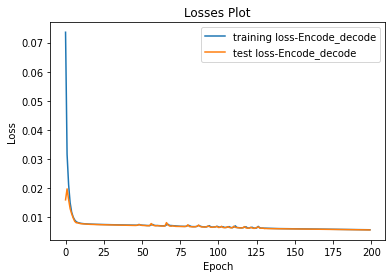

In [3]:
SEED = 42    #42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/d_0.4_EMD/Encode_state_dict.pt'
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'
pathED = '/root/data1/d_0.4_EMD/ED_state_dict.pt'
epochs = 200

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]  #2
in_channels_edge = sample.edge_attr.shape[1]  #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node
batch_size =25       #改25
n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
model.load_state_dict(torch.load(pathED), strict=False)
train_hist, test_hist=train(epochs, model, perm_list,train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,pathED,pathD,pathE)
plot_dir='/root/data1/d_0.4_EMD/loss/'
save_DEplots(train_hist, test_hist,plot_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                patience=5, threshold=0.0000001, threshold_mode='rel',
                                cooldown=0, min_lr=0.000001, eps=1e-08, verbose=True)

In [3]:
SEED = 42    #42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/d_0.4_EMD/Encode_state_dict.pt'
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'
pathED = '/root/data1/d_0.4_EMD/ED_state_dict.pt'
epochs = 200

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
#EDstats_list = get_EDstats(dataset)

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load(dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]  #2
in_channels_edge = sample.edge_attr.shape[1]  #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node
batch_size =25       #改25
n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

cuda
cuda:0
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load(file_path)
print(len(dataset))   #6
n=int(len(dataset)/number_trajectories)
nn=int(n*batch_size)
print(n,nn)#6,150

get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)

file_path_ed= dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input))  #150
print(dataset_input[0])    

for i in range(number_trajectories):
  dataset_=dataset[i*n:(i+1)*n]
  num_=int(dataset_[0].x.shape[0]/(per_t*batch_size))
  loader_ = DataLoader(dataset_,  shuffle=False)
  pred_=torch.tensor([[0,0]]).type(torch.float).to(device)
  #pred_=torch.tensor([[0]]).type(torch.float).to(device)
  per_t=1
  batch_size=25    #改
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  with torch.no_grad():
    for step, data in enumerate(loader_):
      data=data.to(device)
      
      out, _ = model(data, per_t ,perm_list[0], batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
      pred_=torch.vstack((pred_,out))
  pred_=pred_[1:,:]
  print(pred_.shape)   #150*3718,2
  pred_=pred_*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
  dataset_input_=dataset_input[i*nn:(i+1)*nn]

  pred_=pred_.to('cpu')

  viz_data_loader_ = copy.deepcopy(dataset_input_)
  eval_data_loader_ = copy.deepcopy(dataset_input_)


  for j in range(int(pred_.shape[0]/num_)):
    viz_data_loader_[j].x=pred_[j*num_:(j+1)*num_,:]
    eval_data_loader_[j].x=(dataset_input_[j].x-viz_data_loader_[j].x)
  torch.save(viz_data_loader_,dataset_dir+'/encode_decode_output_'+str(i)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#200个data


8
8 200
/root/data1/d_slice_0
601
Done collecting data!
Done saving data!
Output Location:  /root/data1/d_0.4_EMD/meshgraphnets_miniset111traj50200ts_vis.pt
200
Data(x=[7793, 2], edge_index=[2, 45964], edge_attr=[45964, 3], cells=[15190, 3], mesh_pos=[7793, 2])


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


torch.Size([1558600, 2])


查看还原效果

复制到文件夹查看还原效果

In [7]:
for i in range(number_trajectories):
    data=torch.load(dataset_dir+'/encode_decode_output_'+str(i)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    print(len(data))
    print(data[0])
    num=200
    originalFolder='/root/data1/d_slice_'+str(i)
    destinationFolder='/root/data1/d_0.4_dataset_EDoutput_'+str(i)
    fileName="/slice_"
    transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName)

200
Data(x=[7793, 2], edge_index=[2, 45964], edge_attr=[45964, 3], cells=[15190, 3], mesh_pos=[7793, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


生成低维数据

In [8]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)


dataset_dir = '/root/data1/d_0.4_EMD'
path='/root/data1/d_slice_'

get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为150  

/root/data1/d_slice_0
601
Done collecting data!
Done saving data!
Output Location:  /root/data1/d_0.4_EMD/meshgraphnets_miniset12001traj50200ts_vis.pt
1


In [9]:
M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)
with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

200
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [4]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)
a=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
edge_num=a[0].edge_attr.shape[0]
print(edge_num)    #14586

14586


在低维上进行时序预测

训练预测边属性模型

In [ ]:
data_1=[]
data_label_1=[]

for i in range(number_trajectories):
    per_t=1
    dataset_encode=torch.load(dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    per_t=11
    for j in range(len(dataset_encode)-per_t+1):
        for k in range(per_t):
            if k <(per_t-1):
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_1.append(E_data)
            else:
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_label_1.append(E_data)
                       
print(len(data_1))      #140*10
print(len(data_label_1))   #140

data_=data_1
data_label=data_label_1

'''data_2=[]
data_label_2=[]

data_3=[]
data_label_3=[]

for i in range(len(dataset_encode)-per_t+1):
    if i in r_index:
        for j in range(per_t-1):
            E_data  = copy.deepcopy(data_1[i*(per_t-1)+j])
            
            data_2.append(E_data)
        E_data  = copy.deepcopy(data_label_1[i])
        data_label_2.append(E_data)
    else:
        for j in range(per_t-1):
            E_data  = copy.deepcopy(data_1[i*(per_t-1)+j])
            
            data_3.append(E_data)
        E_data  = copy.deepcopy(data_label_1[i])
        data_label_3.append(E_data)

print(len(data_2))      #40*10
print(len(data_label_2))   #40

print(len(data_3))      #100*10
print(len(data_label_3))   #100
    



data_=data_3+data_2
data_label=data_label_3+data_label_2'''



all=data_+data_label



data_stats_list = get_EDstats(all)

torch.save(data_stats_list,dataset_dir+'/data_stats_list.pt')



1900
190


In [5]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 2,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 30,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':26,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 2500,#5000
         'attr_epochs':8000,#8000
         'train_size':140, #45
         'test_size': 50, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/d_0.4_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/d_0.4_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':170,
         'attr_batchsize':5,
        'n_graph_encode':[500,150,80,10],
        'pool_num':[6500,4800,3900]},
]:

        args = objectview(args)
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(5)   #GPU

In [ ]:
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

test_losses, losses, best_model,best_test_loss =gmesh_transformer_train(data_,data_label, device,data_stats_list, args,edge_num)
print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

save_plots(args, losses, test_losses)

cuda


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/2500 [00:30<21:15:14, 30.62s/Epochs]

train loss 1.021499 test loss 1.310246


Training:   4%|▍         | 101/2500 [21:28<10:46:10, 16.16s/Epochs]

train loss 0.050063 test loss 0.048433


Training:   8%|▊         | 201/2500 [42:19<9:30:39, 14.89s/Epochs] 

train loss 0.038576 test loss 0.033156


Training:  12%|█▏        | 301/2500 [58:25<6:36:49, 10.83s/Epochs]

train loss 0.034608 test loss 0.025994


Training:  16%|█▌        | 401/2500 [1:14:14<6:24:31, 10.99s/Epochs]

train loss 0.020615 test loss 0.017844


Training:  20%|██        | 501/2500 [1:30:15<6:51:53, 12.36s/Epochs]

train loss 0.021866 test loss 0.016233


Training:  24%|██▍       | 601/2500 [1:50:06<8:28:20, 16.06s/Epochs]

train loss 0.02066 test loss 0.017699


Training:  28%|██▊       | 701/2500 [2:22:19<7:47:25, 15.59s/Epochs] 

train loss 0.015918 test loss 0.015467


Training:  29%|██▉       | 723/2500 [2:28:56<11:14:59, 22.79s/Epochs]

In [6]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)
data_encode=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_encode))
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

200
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [7]:
device='cuda'
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d        
        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 2,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 30,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':26,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 2500,#5000
         'attr_epochs':8000,#8000
         'train_size':140, #45
         'test_size': 50, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/d_0.4_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/d_0.4_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':170,
         'attr_batchsize':5,
        'n_graph_encode':[500,150,80,10],
        'pool_num':[6500,4800,3900]},
]:
        args = objectview(args)
    
model_name='g_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = MeshGraphNet_transformer(args,edge_num).to(device)
node_model.load_state_dict(torch.load('/root/data1/d_0.4_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))

EDstats_list=torch.load(dataset_dir+'/EDstats_list.pt')
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))

In [8]:
def predict_sequences_multiple(model, data, a, predict_num,seq_len):

        print('[Model] Predicting Sequences Multiple...')
        a=a.to(device)
        code_index=a.edge_index
        for i in range(predict_num):
          list_p = data[:] if i == 0 else data[i:]
          data_loader=DataLoader(list_p, batch_size=seq_len, shuffle=False) 
          for i,batch in enumerate(data_loader):
              batch=batch.to(device)
              code_x,code_edge_attr = gmesh_transformer_pred(batch,a,model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
          
          new_data=Data(x=code_x, edge_index=code_index, edge_attr=code_edge_attr)
          data.append(new_data)

        return data

In [10]:
predict_num=190
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...
200


In [11]:
i=0
batches=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')


perm_list=torch.load(dataset_dir+'/perm_list_150.pt')




decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

200


In [13]:
def ROM_transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName):

    folder = os.path.exists(destinationFolder)

    if not folder: 
        print('start to create the destination folder')   
        os.makedirs(destinationFolder)       
        copyFiles(originalFolder,destinationFolder) 

    print('start to store data as a new variable')
    
    for i in range(number_ts):
        f_filename = destinationFolder + fileName + str(i+satart_number_ts)+ ".vtk"
        reader=vtk.vtkPolyDataReader()
        reader.SetFileName(f_filename)  # SetFileName设置要读取的vtk文件
        reader.ReadAllScalarsOn()
        reader.ReadAllVectorsOn()
        reader.ReadAllTensorsOn()
        reader.Update()

        vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
        num_points=vtkdata.GetNumberOfPoints() 
        point_data =vtkdata.GetPointData()
        a=data[i]
        a=a.to('cpu')
        a=a.numpy()
    
        velocity_array = point_data.GetArray('U')
        #print(velocity_array.GetTuple(0)[0:2])
        for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

        writer = vtk.vtkGenericDataObjectWriter()
        writer.SetFileName(f_filename)
        writer.SetInputData(vtkdata)
        writer.Write()
       
    print('transform succeed')	

In [13]:
for i in range(number_trajectories):
    satart_number_ts=50
    ts=len(pred_x)
    originalFolder='/root/data1/d_slice_'+str(i)
    destinationFolder='/root/data1/ROM_d_0.4_dataset_EDoutput_'+str(predict_num)+str(i)
    fileName="/slice_"
    ROM_transform_vector(pred_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [14]:
def pcc_of_two(ori_data, rom_data):

    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            pcc_x = pearson_value(y_u, y_0_u)
            pcc_y = pearson_value(y_v, y_0_v)
            plt.figure(1)
            plt.plot(pcc_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(pcc_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            pcc = pearson_value(ori_data, rom_data)
            # print(pcc.shape)
            plt.figure(1)
            # x = np.linspace(0,pcc.shape[0], num = pcc.shape[0])
            plt.plot(pcc)
            plt.ylim((0.8, 1))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            plt.show()
    else:
        print('the dimension of these two series are not equal. Please check them.')

200
(200, 15586) (200, 15586)


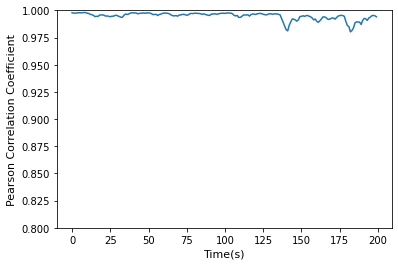

In [15]:
ED_out = pred_x   #60
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:200]

ts=200

for i in range(ts):
    
    uvw=ED_out[i].reshape(1,ED_out[i].shape[0],ED_out[i].shape[1]).to('cpu')
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_ = np.hstack((outputs[:,:,0],outputs[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_.shape,input_.shape)

pcc_of_two(input_, output_)

In [ ]:
def mse(ori_data, rom_data):

    rmse_value = []
    acc=torch.nn.MSELoss(reduction='sum')
    acc1=torch.nn.MSELoss('mean')
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            #value = mean_squared_error(ori_data[i], rom_data[i])
            ori=torch.Tensor(ori_data[i])
            #print(ori.shape)
            rom=torch.Tensor(rom_data[i])
            #value =math.sqrt(acc(ori, rom))
            #print()
            #print((acc(ori, rom)))
            #print(math.sqrt((acc(ori, rom))))
            #print(acc1(ori, rom))
            #print(math.sqrt((acc1(ori, rom))))
            k=(torch.norm(ori, p=1))/len(ori)
            #value=acc1(ori,rom)
            #value =math.sqrt((acc1(ori, rom)))
            value =math.sqrt((acc1(ori, rom)))/k
            #value =math.sqrt((acc(ori, rom)))/(torch.norm(ori, p=1))
            #value =(acc(ori, rom)/torch.pow((torch.norm(ori, p=2)),2))
            #value =math.sqrt(acc(ori, rom)/(torch.pow((torch.norm(ori, p=2)),2)))
            #print(value)
            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value

def mse_of_two(ori_data, rom_data):
    # , rom_data_1):
    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            rmse_x = mse(y_u, y_0_u)
            rmse_y = mse(y_v, y_0_v)
            plt.figure(1)
            plt.plot(rmse_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(rmse_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            rmse_value = mse(ori_data, rom_data)
            # rmse_value_1 = rmse(ori_data, rom_data_1)
            # print(pcc.shape[0], pcc.shape[1])
            plt.figure(1)
            # x = np.linspace(0,rmse_value.shape[0], rmse_value.shape[0])
            # plt.plot(x, rmse_value, x, rmse_value_1)
            plt.plot(rmse_value)
            plt.ylim((0, 0.3))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RRMSE',{'size' : 11})
            # plt.legend(['7', '8'], loc='lower right')   
            plt.show()
    else:
        print('the dimension of these two series are not equal. Please check them.')

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


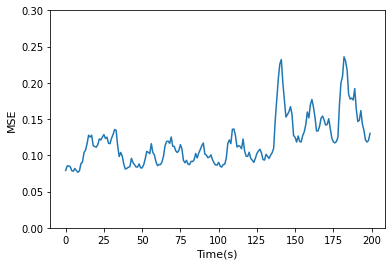

In [17]:
mse_of_two(input_, output_)

得到十个数据

In [1]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from d_pooling import *
#from mgn import *
from d_tap_processing import *
#from global_tpok_mp import *

from d_TAP_MP_Attention import *
from GTF import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 123    #42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
dataset_dir = '/root/data1/d_0.4_EMD'
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)


pathE='/root/data1/d_0.4_EMD/Encode_state_dict.pt'
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'
pathED = '/root/data1/d_0.4_EMD/ED_state_dict.pt'

epochs = 200

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load(dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
train_size=7        #改


in_channels_node = 2 #2
in_channels_edge = 3 #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node
batch_size =25       #改25
n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

cuda
cuda:0


In [3]:
M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)


decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

AttributeError: 'Global_attention' object has no attribute 'min_score'

In [4]:
per_t=1     
satart_number_ts=200
number_ts=10
batch_size = int(number_ts/per_t)
dataset_dir = '/root/data1/d_0.4_EMD'
path='/root/data1/d_slice_'     #将文件命名为yuan_0
number_trajectories=1

#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为1  

perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)




with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))#10
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

1
cuda
cuda:0
10
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26]) Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [5]:
per_t=1     
batch_size = int(number_ts/per_t)
data_encode=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_encode)) #10
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

10
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [6]:
edge_num=a.edge_attr.shape[0]
print(edge_num)#9762

14586


In [9]:
predict_num=100
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60
print(data[0])

[Model] Predicting Sequences Multiple...


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


110
Data(x=[3900, 26], edge_index=[2, 14586], edge_attr=[14586, 26])


In [10]:
torch.save(data,'/root/data1/STGCN_result/GA_d_0.4_110_pred')

In [11]:
i=0
batches=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')




perm_list=torch.load(dataset_dir+'/perm_list_150.pt')


pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

110


In [14]:
for i in range(number_trajectories):
    satart_number_ts=200
    ts=len(pred_x)
    originalFolder='/root/data1/d_slice_'+str(i)
    destinationFolder='/root/data1/ROM_pred_d_0.4_dataset_EDoutput_'+str(predict_num)+str(i)
    fileName="/slice_"
    ROM_transform_vector(pred_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [15]:
def pcc_of_two(ori_data, rom_data):

    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            pcc_x = pearson_value(y_u, y_0_u)
            pcc_y = pearson_value(y_v, y_0_v)
            plt.figure(1)
            plt.plot(pcc_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(pcc_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            pcc = pearson_value(ori_data, rom_data)
            # print(pcc.shape)
            f=plt.figure(1)
            # x = np.linspace(0,pcc.shape[0], num = pcc.shape[0])
            plt.plot(pcc)
            plt.ylim((0.8, 1))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            plt.show()
            f.savefig('/root/data1/d_0.4_EMD/pcc_pre_circle_230.pdf', bbox_inches='tight')
    else:
        print('the dimension of these two series are not equal. Please check them.')

In [16]:
def get(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,path):
  data_list = []

  for i in range(number_trajectories):

    if os.path.isdir(path):
      path_k=path
      print(path_k)
      vtk_num=get_vtk_num(path_k)
      print(vtk_num)
      for ts in range(satart_number_ts,vtk_num):
        
        if(ts==number_ts+satart_number_ts):
          break
        point, cells, velocity=read_vtk_file(path_k+"/slice_"+str(ts+i)+".vtk")
        
        data_list.append(Data(x=velocity))
  return data_list

In [17]:
dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path='/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000'
ED_out=get(number_trajectories,satart_number_ts,number_ts,1,1,path)
print(ED_out)
print(len(ED_out))
ED_out=ED_out[0:110]
path='/root/data1/d_slice_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:110]

/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000
601
[Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2]), Data(x=[7793, 2

(110, 15586) (110, 15586)


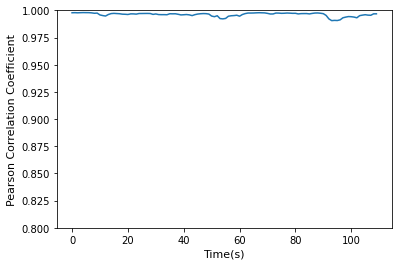

In [18]:
ts=110

for i in range(ts):
    
    uvw=ED_out[i].x.reshape(1,ED_out[i].x.shape[0],ED_out[i].x.shape[1]).to('cpu')
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_ = np.hstack((outputs[:,:,0],outputs[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_.shape,input_.shape)

pcc_of_two(input_, output_)

In [19]:
from keras import backend as K
def mse(ori_data, rom_data):

    rmse_value = []
    acc=torch.nn.MSELoss()
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            #value = mean_squared_error(ori_data[i], rom_data[i])
            ori=torch.Tensor(ori_data[i])
            
            rom=torch.Tensor(rom_data[i])
            
            k=((torch.norm(ori, p=1))/len(ori))
            
            #value =acc(ori, rom)
            
            #value =math.sqrt(acc(ori, rom))
            value=math.sqrt(acc(ori,rom))/k
            #value =math.sqrt((acc(ori, rom))/(torch.norm(ori, p=1)))
           
            #value =math.sqrt(acc(ori, rom)/(torch.pow((torch.norm(ori, p=2)),2)/len(ori)))
            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value

def mse_of_two(ori_data, rom_data):
    # , rom_data_1):
    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            rmse_x = mse(y_u, y_0_u)
            rmse_y = mse(y_v, y_0_v)
            plt.figure(1)
            plt.plot(rmse_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(rmse_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            rmse_value = mse(ori_data, rom_data)
            # rmse_value_1 = rmse(ori_data, rom_data_1)
            # print(pcc.shape[0], pcc.shape[1])
            plt.figure(1)
            # x = np.linspace(0,rmse_value.shape[0], rmse_value.shape[0])
            # plt.plot(x, rmse_value, x, rmse_value_1)
            plt.plot(rmse_value)
            plt.ylim((0, 0.3))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RRMSE',{'size' : 11})
            # plt.legend(['7', '8'], loc='lower right')   
            plt.show()
    else:
        print('the dimension of these two series are not equal. Please check them.')

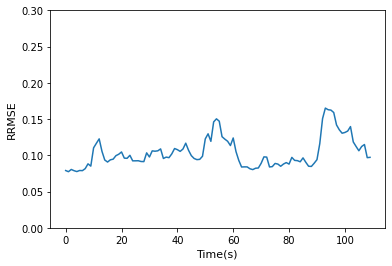

In [20]:
mse_of_two(input_, output_)

In [21]:
def point_over_time(ori_data, edg_data,j,ts , fieldName,path):
        point = [0,ts]
       
        x = np.linspace(point[0],int(point[1]-1),int(point[1]-point[0]))
        y_u=[]
        y_1_u=[]
        for i in range(ts):
            y_u.append(ori_data[i].x[j,0])
            y_1_u.append(edg_data[i].x[j,0])
        print(len(y_u))
        f = plt.figure()
        plt.plot(x, y_u,'k',  linewidth = 0.7)
        plt.plot(x, y_1_u, 'r--', linewidth = 0.7)
        plt.xlim((point[0], point[1]))# range
        plt.ylim((-5, 5))

        plt.title(fieldName + ' Magnitude')
        plt.xlabel('Time(s)')
        plt.ylabel(fieldName)
        
        plt.legend(['Full Model', 'Global Aware Graph Neural Networks'], loc='upper right')
        #f.savefig('/root/data1/EMD/'+str(j)+'velocity.pdf', bbox_inches='tight')
        f.savefig(path, bbox_inches='tight')

110
tensor([ 0.0424, -0.0221])
110


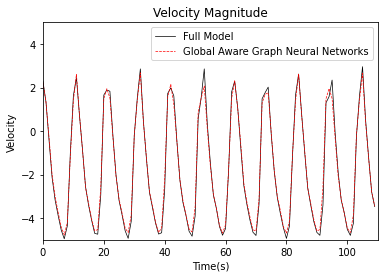

In [22]:
number_trajectories=1
satart_number_ts=200
number_ts=110
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:110]
ts=110
j=1704#7793
fieldName='Velocity'
print(ori[0].mesh_pos[j]) 
path='/root/data1/d_0.4_EMD/'+str(j)+'velocity.pdf'
point_over_time(ori, ED_out,j,ts , fieldName,path)

In [23]:
print(ori[0].mesh_pos[6704]) 

tensor([0.1758, 0.0078])


时间

In [1]:
import torch
import copy
import time
from GTF import *
from torch_geometric.data import Data
from d_TAP_MP_Attention import *
from d_tap_processing import * 


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_encode=torch.load('/root/data1/d_0.4_EMD/M_encode_output_01traj11020010ts_vis.pt')
data=copy.deepcopy(data_encode[0:10])
device ='cpu'    #cuda
for i in range(len(data)):
    data[i].x=data[i].x.to(device)
    data[i].edge_index=data[i].edge_index.to(device)
    data[i].edge_attr=data[i].edge_attr.to(device)
a=copy.deepcopy(data[0])
edge_num=a.edge_attr.shape[0]
print(edge_num)

14586


In [3]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 2,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 30,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':26,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 2500,#5000
         'attr_epochs':8000,#8000
         'train_size':140, #45
         'test_size': 50, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/d_0.4_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/d_0.4_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':170,
         'attr_batchsize':5,
        'n_graph_encode':[500,150,80,10],
        'pool_num':[6500,4800,3900]},
]:
        args = objectview(args)    
model_name='g_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = MeshGraphNet_transformer(args,edge_num)
node_model.load_state_dict(torch.load('/root/data1/d_0.4_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))

EDstats_list=torch.load('/root/data1/d_0.4_EMD/EDstats_list.pt')
data_stats_list=torch.load('/root/data1/d_0.4_EMD/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list

In [4]:
in_channels_node = 2 #2
in_channels_edge = 3 #3
hidden_channels = 26#24    #22#12
out_channels = in_channels_node
batch_size =25       #改25
n_mlp_encode = 4
n_mlp_mp = 5#5
encoding_dim=32#32
ae_dim=[160,128,64,32]#[128,64,32,16,10][300,128,64,32]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[6500,4800,3900]#[2000,1500,1200,1000][2000,1600,1400,1000]
act = F.elu
param_sharing = False
pathD='/root/data1/d_0.4_EMD/Decode_state_dict.pt'

In [5]:
decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)

<All keys matched successfully>

In [6]:
list_p=data
data_loader=DataLoader(list_p, batch_size=10, shuffle=False) 
batches=torch.load('/root/data1/d_0.4_EMD/20001trajbatches.pt')
for i in range(len(batches)):
    batches[i]=batches[i].to(device)    
xs=torch.load('/root/data1/d_0.4_EMD/20001trajxs.pt')
for i in range(len(xs)):
    xs[i]=xs[i].to(device) 
positions=torch.load('/root/data1/d_0.4_EMD/20001trajpositions.pt')
for i in range(len(positions)):
    positions[i]=positions[i].to(device) 
edge_attrs=torch.load( '/root/data1/d_0.4_EMD/20001trajedge_attrs.pt')
for i in range(len(edge_attrs)):
    edge_attrs[i]=edge_attrs[i].to(device)
edge_indices=torch.load( '/root/data1/d_0.4_EMD/20001trajedge_indices.pt')
for i in range(len(edge_indices)):
    edge_indices[i]=edge_indices[i].to(device)
edge_masks=torch.load('/root/data1/d_0.4_EMD/20001trajedge_masks.pt')
for i in range(len(edge_masks)):
    edge_masks[i]=edge_masks[i].to(device)
perm_list=torch.load('/root/data1/d_0.4_EMD/perm_list_150.pt')

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [29]:
time_start=time.time()
for i,batch in enumerate(data_loader):
    code_x,code_edge_attr = gmesh_transformer_pred(batch,a,node_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
    print(time.time() - time_start)
#new_data=Data(x=code_x, edge_index=a.edge_index, edge_attr=code_edge_attr)
#with torch.no_grad():
        #x=decode_model(new_data, batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
        #x=x*EDstd_vec_x+EDmean_vec_x


0.5009963512420654


In [9]:
for i,batch in enumerate(data_loader):
    code_x,code_edge_attr = gmesh_transformer_pred(batch,a,node_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)

0.005863189697265625


3900与5100对比

In [28]:
def cc(ori_data, rom_data_0, rom_data_1):
    pcc_0 = pearson_value(ori_data, rom_data_0)
    pcc_1 = pearson_value(ori_data, rom_data_1)
    
    fig, ax = plt.subplots()
    x = np.linspace(0,pcc_0.shape[0],pcc_0.shape[0])
    print(pcc_0.shape, pcc_1.shape)
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc'], linestyle = ['-', '-'])
    y_0 = pcc_0
    y_1 = pcc_1
    
   
    ax.plot(x, y_0, x, y_1)
     
            # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0.98, 1))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            # plt.xticks(np.arange(0,200.1,25))
            # plt.yticks(np.arange(0.97,1.0001,0.01))
            # plt.legend(['D4:AE+TF', 'D8:AE+TF', 'D12:AE+TF', 'D4:PCA+TF', 'D8:PCA+TF', 'D12:PCA+TF'], loc='lower right')   
    plt.legend(['5100', '3900'], loc='lower right')   

    plt.show()
    fig.savefig('/root/data1/d_0.4_EMD/'+'Pcc.pdf', bbox_inches='tight')

In [25]:
dataset_dir_1 = '/root/data1/d_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path_1='/root/data1/ROM_pred_d_dataset_EDoutput_1000'
ED_out_1=get(number_trajectories,satart_number_ts,number_ts,1,1,path_1)
#print(ED_out_1)
print(len(ED_out_1))
ED_out_1=ED_out_1[0:110]

/root/data1/ROM_pred_d_dataset_EDoutput_1000
601
110


In [26]:
dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path_2='/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000'
ED_out_2=get(number_trajectories,satart_number_ts,number_ts,1,1,
path_2)
#print(ED_out_2)
print(len(ED_out_2))
ED_out_2=ED_out_2[0:110]
path='/root/data1/d_slice_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:110]

/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000
601
110
110


(110, 15586) (110, 15586) (110, 15586)
(110, 1) (110, 1)


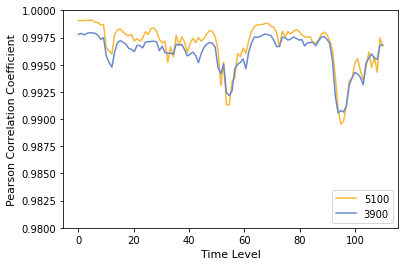

In [29]:
ts=110

for i in range(ts):
    
    uvw_1=ED_out_1[i].x.reshape(1,ED_out_1[i].x.shape[0],ED_out_1[i].x.shape[1]).to('cpu')
    uvw_2=ED_out_2[i].x.reshape(1,ED_out_2[i].x.shape[0],ED_out_2[i].x.shape[1]).to('cpu')
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_1.shape,output_2.shape,input_.shape)

cc(input_, output_1,output_2)

In [30]:
def rrmse(ori_data, rom_data):

    rmse_value = []
    acc=torch.nn.MSELoss()
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            #value = mean_squared_error(ori_data[i], rom_data[i])
            ori=torch.Tensor(ori_data[i])
            
            rom=torch.Tensor(rom_data[i])
            
            k=((torch.norm(ori, p=1))/len(ori))
            
            #value =acc(ori, rom)
            
            #value =math.sqrt(acc(ori, rom))
            value=math.sqrt(acc(ori,rom))/k
            #value =math.sqrt((acc(ori, rom))/(torch.norm(ori, p=1)))
           
            #value =math.sqrt(acc(ori, rom)/(torch.pow((torch.norm(ori, p=2)),2)/len(ori)))
            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value
def rmse_over_time(ori_data, rom_data_0, rom_data_1):
    rmse_0 = rrmse(ori_data, rom_data_0)
    rmse_1 = rrmse(ori_data, rom_data_1)

    fig, ax = plt.subplots()
    x = np.linspace(0,rmse_0.shape[0],rmse_0.shape[0])
    ax.set_prop_cycle(color = ['#f6b93b','#6a89cc'], linestyle = ['-', '-'])
    # x = np.linspace(0,15,2875)
    y_0 = rmse_0
    y_1 = rmse_1
   
    ax.plot(x, y_0, x, y_1)
    # , x, rmse_4, linewidth = 0.6)
    # plt.xlim((-0.1, 200.1))# range
    plt.ylim((-0.005, 0.3))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('RRMSE',{'size' : 11})
    # plt.xticks(np.arange(0,200.1,25))
    # plt.yticks(np.arange(0,0.081,0.02))
    plt.legend(['5100', '3900'], loc='upper right')   
    plt.show()
    fig.savefig('/root/data1/d_0.4_EMD/'+'RMSE.pdf', bbox_inches='tight')

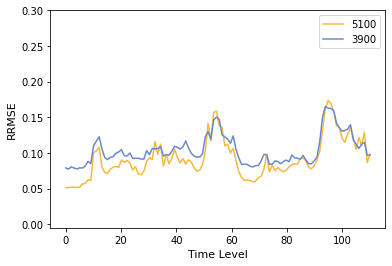

In [31]:
rmse_over_time(input_,output_1, output_2)

In [ ]:
def point_over_time(ori_data,rom_data_0, rom_data_1, j,ts , fieldName):
        point = [0,ts]
        x = np.linspace(point[0],int(point[1]-1),int(point[1]-point[0]))
        y_u=[]
        y_0_u=[]
        y_1_u=[]
       
        for i in range(ts):
            y_u.append(ori_data[i].x[j,0])
            y_0_u.append(rom_data_0[i].x[j,0])
            y_1_u.append(rom_data_1[i].x[j,0])
            
        print(len(y_u))
        fig, ax = plt.subplots()
        ax.set_prop_cycle(color = ['#2f3542','#ff6b81','#6a89cc'], linestyle = ['-','-', '-'])
        ax.plot(x, y_u, x, y_0_u,x, y_1_u,  linewidth = 0.6)

        plt.ylim((-7, 7))

        
        plt.xlabel('Time(s)')
        plt.ylabel(fieldName)
        
        plt.legend(['Full Model','5100', '3900'], loc='lower right')
        fig.savefig('/root/data1/d_0.4_EMD/5100-3900duibi'+str(j)+'velocity.pdf', bbox_inches='tight')

tensor([ 0.1608, -0.0207])
110


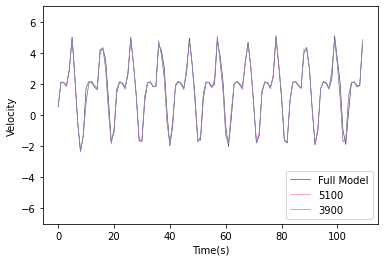

In [33]:
fieldName='Velocity'
j=1900
print(ori[0].mesh_pos[j]) 

ts=110
point_over_time(ori, ED_out_1,ED_out_2,j,ts , fieldName)

In [2]:
dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path='/root/data1/d_slice_'
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:110]

110


In [5]:
j=1704
print(ori[0].mesh_pos[j]) 

tensor([ 0.0424, -0.0221])


In [4]:
dataset_dir_1 = '/root/data1/d_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path_1='/root/data1/ROM_pred_d_dataset_EDoutput_1000'
ED_out_1=get(number_trajectories,satart_number_ts,number_ts,1,1,path_1)
#print(ED_out_1)
print(len(ED_out_1))
ED_out_1=ED_out_1[0:110]

dataset_dir = '/root/data1/d_0.4_EMD'
number_trajectories=1
satart_number_ts=200
number_ts=110
path_2='/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000'
ED_out_2=get(number_trajectories,satart_number_ts,number_ts,1,1,path_2)
print(len(ED_out_2))
ED_out_2=ED_out_2[0:110]

path='/root/data1/d_slice_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:110]



/root/data1/ROM_pred_d_dataset_EDoutput_1000
601
110
/root/data1/ROM_pred_d_0.4_dataset_EDoutput_1000
601
110
110


In [15]:
def vtk_vector(ori,data,i,destination_vtu_path_0):
    
    reader=vtk.vtkPolyDataReader()
    reader.SetFileName(destination_vtu_path_0)  # SetFileName设置要读取的vtk文件
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.ReadAllTensorsOn()
    reader.Update()

    vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
    num_points=vtkdata.GetNumberOfPoints() 
    point_data =vtkdata.GetPointData()
    
    a=ori[i].x-data[i].x
    print(a.shape)
    a=a.to('cpu')
    a=a.numpy()
    
    velocity_array = point_data.GetArray('U')
        #print(velocity_array.GetTuple(0)[0:2])
    for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

    writer = vtk.vtkGenericDataObjectWriter()
    writer.SetFileName(destination_vtu_path_0)
    writer.SetInputData(vtkdata)
    writer.Write()
       
    print('transform succeed')

In [22]:

import shutil
 
def copy_vtu_file(source_path, destination_path):
    shutil.copy2(source_path, destination_path)
 
# 使用方法
t=5

source_vtu_path = '/root/data1/d_slice_0/slice_' + str(t+satart_number_ts)+ ".vtk"

In [23]:
destination_vtu_path_0 = '/root/data1/d_0.4_EMD/5100_slice_' + str(t+satart_number_ts)+ ".vtk"
destination_vtu_path_1 = '/root/data1/d_0.4_EMD/3900_slice_' + str(t+satart_number_ts)+ ".vtk"

copy_vtu_file(source_vtu_path, destination_vtu_path_0)
copy_vtu_file(source_vtu_path, destination_vtu_path_1)

vtk_vector(ori,ED_out_1,t,destination_vtu_path_0)
vtk_vector(ori,ED_out_2,t,destination_vtu_path_1)



torch.Size([7793, 2])
transform succeed
torch.Size([7793, 2])
transform succeed


In [ ]:
edge_data_1=[]
edge_data_label_1=[]
per_t=2
for i in range(number_trajectories):
    dataset_encode=torch.load(dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    for j in range(number_ts-(per_t-1)):
        if (j%per_t)==0:
            E_data  = copy.deepcopy(dataset_encode[j+per_t-2])
            E_data=E_data.to('cpu')
            edge_data_1.append(E_data)     
        
            E_data_  = copy.deepcopy(dataset_encode[j+per_t-1])
            E_data_=E_data_.to('cpu')
            edge_data_label_1.append(E_data_)
                       
print(len(edge_data_1))
print(len(edge_data_label_1))



edge_data=[]
edge_data_label=[]
for i in range(int(len(edge_data_label_1)/number_trajectories)):
     for k in range(number_trajectories):
          edge_data.append(edge_data_1[i+k*int(len(edge_data_1)/number_trajectories)])
          edge_data_label.append(edge_data_label_1[i+k*int(len(edge_data_label_1)/number_trajectories)])
          
print(len(edge_data))
print(len(edge_data_label))

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
       
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 3,
         'batchsize': 10,       #是lable上的batchsize
         'hidden_dim': 300,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':12,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 3000,#5000
         'attr_epochs':8000,#8000
         'train_size':200, #45
         'test_size': 100, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/circle_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/circle_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 10,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 5,
         'n_layers': 3,
         'ff_dim': 64,
         'seq_len': 1,        #改per_t-1,二推一
         'per_t':2,
         'attr_train_size':200,
         'attr_batchsize':10,
        'n_graph_encode':[500,150,80,8],
        'pool_num':[2000,1500,1400,1200,1000]},
]:


        args = objectview(args)
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')

In [ ]:
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(SEED)   #GPU

data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')


device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

test_losses, losses, best_model,best_test_loss =edge_gnn_train(edge_data,edge_data_label, device,data_stats_list, args)
     
print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

save_plots(args, losses, test_losses)

预测edge_attr

In [ ]:
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')

model =  edge_gnn(args)
model_name='edge_gnn_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.attr_batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.attr_epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)
model.load_state_dict(torch.load('/root/data1/circle_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))


y=edge_pred(edge_data,model,data_stats_list)

print(len(y))

训练node_x模型

In [ ]:

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 3,
         'batchsize': 10,       #是lable上的batchsize
         'hidden_dim': 300,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':12,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 3000,#5000
         'attr_epochs':8000,#8000
         'train_size':200, #45
         'test_size': 100, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/circle_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/circle_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 10,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 5,
         'n_layers': 3,
         'ff_dim': 64,
         'seq_len': 1,        #改per_t-1,二推一
         'per_t':2,
         'attr_train_size':200,
         'attr_batchsize':10,
        'n_graph_encode':[500,150,80,8],
        'pool_num':[2000,1500,1400,1200,1000]},
]:

        args = objectview(args)
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(SEED)   #GPU

data_1=[]
data_label_1=[]
per_t=2
for i in range(number_trajectories):
    dataset_encode=dataset_encode=torch.load(dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    for j in range(number_ts):
        if (j%per_t)<(per_t-1):
            E_data  = copy.deepcopy(dataset_encode[j])
            E_data=E_data.to('cpu')
            data_1.append(E_data)     
        else:
            
            E_data  = copy.deepcopy(dataset_encode[j])
            E_data=E_data.to('cpu')
            data_label_1.append(E_data)
                       
print(len(data_1))
print(len(data_label_1))

data_=[]
data_label=[]
for i in range(int(len(data_label_1)/number_trajectories)):
     for k in range(number_trajectories):
          for j in range(per_t-1):
              data_.append(data_1[i*(per_t-1)+j+k*int(len(data_1)/number_trajectories)])
          data_label.append(data_label_1[i+k*int(len(data_label_1)/number_trajectories)])
          
print(len(data_))
print(len(data_label))

'''data_1=[]
data_label_1=[]
per_t=2
for i in range(number_trajectories):
    dataset_encode=dataset_encode=torch.load(dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    for j in range(number_ts-per_t+1):
            for k in range(per_t):
                 if k<per_t-1:
                       E_data  = copy.deepcopy(dataset_encode[j+k])
                       E_data=E_data.to('cpu')
                       data_1.append(E_data)   
                 else:
                       E_data  = copy.deepcopy(dataset_encode[j+1])
                       E_data=E_data.to('cpu')
                       data_label_1.append(E_data)
                       
print(len(data_1))    #592
print(len(data_label_1)) #592'''

'''data_=[]
data_label=[]
for i in range(int(len(data_label_1)/number_trajectories)):
     for k in range(number_trajectories):
          for j in range(per_t-1):
              data_.append(data_1[i*(per_t-1)+j+k*int(len(data_1)/number_trajectories)])
          data_label.append(data_label_1[i+k*int(len(data_label_1)/number_trajectories)])
          
print(len(data_))
print(len(data_label)) '''



#all=data_+data_label



#data_stats_list = get_EDstats(all)

#torch.save(data_stats_list,dataset_dir+'/data_stats_list.pt')
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

test_losses, losses, best_model,best_test_loss = gmesh_train(
     data_,data_label, device,data_stats_list, args)
print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

save_plots(args, losses, test_losses)

给定两个时刻点，预测之后的时刻

In [ ]:
#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))
data=copy.deepcopy(data_list_ori[0:2])

In [ ]:
encode_model=GNN_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,

                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act, 
                name='gnn_topk')

encode_model.load_state_dict(torch.load(pathE), strict=False)
encode_model.to(device)


decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)


class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 3,
         'batchsize': 10,       #是lable上的batchsize
         'hidden_dim': 300,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':12,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 5000,#5000
         'attr_epochs':8000,#8000
         'train_size':150, #45
         'test_size': 50, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/circle_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/circle_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 10,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 5,
         'n_layers': 3,
         'ff_dim': 64,
         'seq_len': 2,        #改per_t-1,二推一
         'per_t':3,
         'attr_train_size':150,
         'attr_batchsize':10,
        'n_graph_encode':[500,150,80,8],
        'pool_num':[2000,1500,1400,1200,1000]},
]:

        args = objectview(args)

edge_model =  edge_gnn(args).to(device)
model_name='edge_gnn_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.attr_batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.attr_epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)
edge_model.load_state_dict(torch.load('/root/data1/circle_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))



model_name='g_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = MeshGraphNet_transformer(args).to(device)
node_model.load_state_dict(torch.load('/root/data1/circle_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))


predict_num=5
seq_len=4
EDstats_list=torch.load(dataset_dir+'/EDstats_list.pt')
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))
edge_index_ori=data[0].edge_index
edge_attr_ori=data[0].edge_attr
cells_ori=data[0].cells
mesh_pos_ori=data[0].mesh_pos
for i in range(predict_num):
    list_p = data[:] if i == 0 else data[i:]
    with torch.no_grad():
        data_pred_list, batches , xs, positions, edge_attrs, edge_indices, edge_masks,perms=encode_model(list_p,seq_len,per_t,EDmean_vec_x,
                                                                                                    EDstd_vec_x,EDmean_vec_edge,
                                                                                                    EDstd_vec_edge)
        edge_index_new=data_pred_list[-1].edge_index
        edge_new_data=edge_gnn_pred(data_pred_list[-1],edge_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
        edge_attr_new=edge_new_data.edge_attr
        #将data_pred_list变成batch=2的一张大图，记为data_loader
        data_loader=DataLoader(data_pred_list, batch_size=seq_len, shuffle=False) 
        for i,batch in enumerate(data_loader):
             
             node_new_data=gmesh_transformer_pred(batch,edge_new_data,node_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
        new_data=Data(x=node_new_data, edge_index=edge_index_new, edge_attr=edge_attr_new)
        
    with torch.no_grad():
        x=decode_model(new_data, batches , xs, positions, edge_attrs, edge_indices, edge_masks,perms)
        x=x*EDstd_vec_x+EDmean_vec_x
    data.append(Data(x=x, edge_index=edge_index_ori, edge_attr=edge_attr_ori,cells=cells_ori,mesh_pos=mesh_pos_ori))#这里是和取得时候一样的

print(len(data))

In [ ]:
ED_out = data[:]
ori=copy.deepcopy(data_list_ori[:9])



for i in range(len(ori)):
    
    ED_out[i].to('cpu')
    ori[i].to('cpu')

    uvw=ED_out[i].x[:,0].reshape(1,ED_out[i].x.shape[0])
    ouvw=ori[i].x[:,0].reshape(1,ori[i].x.shape[0])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))
print(inputs.shape)
print(outputs.shape)


pcc_of_two(inputs, outputs)

In [ ]:
mse_of_two(inputs, outputs)

In [ ]:
ED_out = data[2:]
ori=copy.deepcopy(data_list_ori[2:4])



for i in range(len(ori)):
    
    ED_out[i].to('cpu')
    ori[i].to('cpu')

    uvw=ED_out[i].x[:,1].reshape(1,ED_out[i].x.shape[0])
    ouvw=ori[i].x[:,1].reshape(1,ori[i].x.shape[0])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))
print(inputs.shape)
print(outputs.shape)


pcc_of_two(inputs, outputs)

In [ ]:
mse_of_two(inputs, outputs)

In [ ]:
def all_rom_pred(predict_num,seq_len,data,per_t,
                 encode_model,decode_model,edge_model,node_model,EDmean_vec_x,EDstd_vec_x,
                 EDmean_vec_edge,EDstd_vec_edge,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
    data_pred=[]

    for i in range(predict_num-1):

        list_p = data[i] 
        print(list_p)
        with torch.no_grad():
            data_pred_list, batches , xs, positions, edge_attrs, edge_indices, edge_masks,perms=encode_model(list_p,seq_len,per_t,EDmean_vec_x,
                                                                                                    EDstd_vec_x,EDmean_vec_edge,
                                                                                                    EDstd_vec_edge)
            
            edge_index_new=data_pred_list[-1].edge_index
            edge_new_data=edge_gnn_pred(data_pred_list[-1],edge_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            edge_attr_new=edge_new_data.edge_attr
            #将data_pred_list变成batch=2的一张大图，记为data_loader
            data_loader=DataLoader(data_pred_list, batch_size=seq_len, shuffle=False) 
            for i,batch in enumerate(data_loader):
             
                 node_new_data=gmesh_pred(batch,node_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
                 
            new_data=Data(x=node_new_data, edge_index=edge_index_new, edge_attr=edge_attr_new)
        
        with torch.no_grad():
            x=decode_model(new_data, batches , xs, positions, edge_attrs, edge_indices, edge_masks,perms)
            x=x*EDstd_vec_x+EDmean_vec_x
        data_pred.append(x)
    return data_pred

In [ ]:
from mmp import *
encode_model=GNN_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,

                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act, 
                name='gnn_topk')

encode_model.load_state_dict(torch.load(pathE), strict=False)
encode_model.to(device)


decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)


class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
       
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 3,
         'batchsize': 10,       #是lable上的batchsize
         'hidden_dim': 300,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':12,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 3000,#5000
         'attr_epochs':8000,#8000
         'train_size':200, #45
         'test_size': 100, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/circle_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/circle_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 10,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 5,
         'n_layers': 3,
         'ff_dim': 64,
         'seq_len': 1,        #改per_t-1,二推一
         'per_t':2,
         'attr_train_size':200,
         'attr_batchsize':10,
        'n_graph_encode':[500,150,80,8],
        'pool_num':[2000,1500,1400,1200,1000]},
]:

        args = objectview(args)

edge_model =  edge_gnn(args).to(device)
model_name='edge_gnn_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.attr_batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.attr_epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)
edge_model.load_state_dict(torch.load('/root/data1/circle_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))



model_name='g_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = MeshGraphNet(args).to(device)
node_model.load_state_dict(torch.load('/root/data1/circle_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))

In [ ]:
#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))
#data=copy.deepcopy(data_list_ori[0:2])

EDstats_list=torch.load(dataset_dir+'/EDstats_list.pt')
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))

In [ ]:
ED_out = list_data
ori=torch.load('/root/data1/EMD/meshgraphnets_miniset111traj300ts_vis.pt')
ori=ori[280:299]

print(ED_out[0])
print(ori[0])
ts=8

for i in range(ts):
    
    uvw=ED_out[i].x.reshape(1,ED_out[i].x.shape[0],ED_out[i].x.shape[1])
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs = uvw if i==1 else np.vstack((outputs,uvw))
    inputs=ouvw if i==1 else np.vstack((inputs,ouvw))

output_ = np.hstack((outputs[:,:,0],outputs[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_.shape,input_.shape)

pcc_of_two(input_, output_)

In [ ]:
predict_num=150
per_t=2
seq_len=1
a=[]
for k in range(number_trajectories):
    data_list_= data_list_ori[k*int(len(data_list_ori)/number_trajectories):(k+1)*int(len(data_list_ori)/number_trajectories)]
    print(len( data_list_))
    data_pred=all_rom_pred(predict_num,seq_len,data_list_,per_t,
                 encode_model,decode_model,edge_model,node_model,EDmean_vec_x,EDstd_vec_x,
                 EDmean_vec_edge,EDstd_vec_edge,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
   
        
    a=a+data

print(len(a))

In [ ]:
ED_out = a[:]
print(len(ED_out))
ori=copy.deepcopy(data_list_ori[:])
print(len(ori))



for i in range(int(len(ori)/number_trajectories)):
    
    ED_out[i].to('cpu')
    ori[i].to('cpu')

    uvw=ED_out[i].x[:,0].reshape(1,ED_out[i].x.shape[0])
    ouvw=ori[i].x[:,0].reshape(1,ori[i].x.shape[0])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))
print(inputs.shape)
print(outputs.shape)


pcc_of_two(inputs, outputs)

In [ ]:
mse_of_two(inputs, outputs)

In [ ]:
ED_out = a[:]
print(len(ED_out))
ori=copy.deepcopy(data_list_ori[:])
print(len(ori))



for i in range(int(len(ori)/number_trajectories)):
    i=i+int(len(ori)/number_trajectories)
    
    ED_out[i].to('cpu')
    ori[i].to('cpu')
    

    uvw=ED_out[i].x[:,0].reshape(1,ED_out[i].x.shape[0])
    ouvw=ori[i].x[:,0].reshape(1,ori[i].x.shape[0])
    outputs = uvw if i==150 else np.vstack((outputs,uvw))
    inputs=ouvw if i==150 else np.vstack((inputs,ouvw))
print(inputs.shape)
print(outputs.shape)


pcc_of_two(inputs, outputs)

In [ ]:
mse_of_two(inputs, outputs)

In [ ]:
ED_out = a[:]
print(len(ED_out))
ori=copy.deepcopy(data_list_ori[:])
print(len(ori))



for i in range(int(len(ori)/number_trajectories)):
    i=i+2*int(len(ori)/number_trajectories)
    
    ED_out[i].to('cpu')
    ori[i].to('cpu')
    

    uvw=ED_out[i].x[:,0].reshape(1,ED_out[i].x.shape[0])
    ouvw=ori[i].x[:,0].reshape(1,ori[i].x.shape[0])
    outputs = uvw if i==300 else np.vstack((outputs,uvw))
    inputs=ouvw if i==300 else np.vstack((inputs,ouvw))
print(inputs.shape)
print(outputs.shape)


pcc_of_two(inputs, outputs)

In [ ]:
mse_of_two(inputs, outputs)

In [ ]:
ED_out = a[:]
print(len(ED_out))
ori=copy.deepcopy(data_list_ori[:])
print(len(ori))



for i in range(int(len(ori)/number_trajectories)):
    i=i+3*int(len(ori)/number_trajectories)
    
    ED_out[i].to('cpu')
    ori[i].to('cpu')
    

    uvw=ED_out[i].x[:,0].reshape(1,ED_out[i].x.shape[0])
    ouvw=ori[i].x[:,0].reshape(1,ori[i].x.shape[0])
    outputs = uvw if i==450 else np.vstack((outputs,uvw))
    inputs=ouvw if i==450 else np.vstack((inputs,ouvw))
print(inputs.shape)
print(outputs.shape)


pcc_of_two(inputs, outputs)

In [ ]:
mse_of_two(inputs, outputs)

复制到文件夹查看效果ROM

In [ ]:
for i in range(number_trajectories):
    data=a[i*int(len(a)/number_trajectories):(i+1)*int(len(a)/number_trajectories)]
    torch.save(data,dataset_dir+'/ROM_circle_data'+str(i)+str(number_trajectories)+'traj'+str(number_ts)+'ts_vis.pt')
    print(len(data))   #150
    print(data[0])
    num=150
    originalFolder='/root/data1/dataset_'+str(i)
    destinationFolder='/root/data1/ROM_circledataset_EDoutput_'+str(i)
    fileName="/circle-2d-drag_"
    transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName)

某一点的全时间速度曲线

In [ ]:
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))

In [ ]:
edg_data=torch.load(dataset_dir+'/ROM_circle_data'+str(0)+str(number_trajectories)+'traj'+str(number_ts)+'ts_vis.pt')
j=3694   #(0,3718)
fieldName='Velocity'
#fieldName='Temperature'

dataset_input=data_list_ori[0:150]
print(dataset_input[0].mesh_pos[j]) 

path_t='/root/data1/circle_EMD/'+str(j)+str(0)+str(number_trajectories)+'velocity.pdf'

point_over_time(dataset_input, edg_data,j,number_ts,fieldName,path_t)

对比试验

In [ ]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


from pooling import *
from mgn import *
from processing import *
#from global_tpok_mp import *
from MP_ED import *

In [ ]:
number_trajectories=4
number_ts=150   #600
satart_number_ts=50
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.1
batch_size = 25
dataset_dir = '/root/data1/circle_EMD'
path='/root/data1/dataset_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

In [ ]:
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python


pathE='/root/data1/circle_EMD/MP_Encode_state_dict.pt'
pathD='/root/data1/circle_EMD/MP_Decode_state_dict.pt'
pathED = '/root/data1/circle_EMD/MP_ED_state_dict.pt'
epochs = 500
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=18        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 12    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6
encoding_dim=10
ae_dim=[128,64,32,16,10]
n_mp_down = [2,2,1,1,1]
n_mp_up= [1,1,1,2,2]
pool_num = [2000,1500,1200,1000]

act = F.elu
param_sharing = False

model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
#model.load_state_dict(torch.load(pathED), strict=False)
train_hist, test_hist=train(epochs, model, train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,pathED,pathD,pathE)
plot_dir='/root/data1/circle_EMD/MP_loss/'
save_DEplots(train_hist, test_hist,plot_dir)
